In [ ]:
# Subset of results, may contain results not published in paper (due to lack of significance for example)
# If anything seem to be missing, feel free to contact us

In [1]:
# Import all necessary packages
import pandas as pd
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import functools
import itertools
from collections import defaultdict
import os

from sklearn.preprocessing import QuantileTransformer

In [2]:
is_books = False
pre_study_questions = {
    "q1": "1. Do you know what recommender systems are and how they work?",
    "q2": "2. Have you heard of the term 'relevance' in the context of recommendations before?",
    "q3": "3. Have you heard of the term 'diversity' in relation to recommendations previously?",
    "q4": "4. Have you heard of the term 'novelty' when discussing recommendations before?",
    "q5": "5. Have you heard of the term 'exploration' in the context of recommendations before?",
    "q6": "6. Have you heard of the term 'exploitation' (familiarity) in relation to recommendations before?",
    "q7": "7. Please choose the statement that best describes what relevant recommendations mean to you",
    "q8": "8. Please select the statement that best describes what diverse recommendations mean to you",
    "q9": "9. Please choose the statement that best describes what novel recommendations mean to you",
    "q10": "10. Please choose the statement that best describes what exploratory recommendations mean to you",
    "q11": "11. Please select the statement that best describes what exploitational (familiar) recommendations mean to you",
    "q12": "12. How frequently do you find yourself reading books?" if is_books else "How often do you typically engage in watching movies?"
}

q7_answers = {
    '0': 'Providing items that match my with my existing interests.',
    '1': 'Providing items that I can utilize right now.',
    '2': 'Helping me to understand the variety of the offer.',
    '3': 'Helping me to find unexpected yet interesting items.',
    'other': 'Other'
}

q8_to_q11_answers = {
    '0': 'Providing items that are highly different from the ones you consumed so far (e.g., genres you never watched so far).',
    '1': 'Showing you a selection of very heterogeneous items (e.g., each one having a different set of genres).',
    '2': 'Providing niche items that are not much known in general.',
    '3': 'Providing items that are very similar to the ones you consumed so far (e.g., genres you are used to watch).',
    'other': 'Other'
}

q1_answers = {
    '-2': 'No',
    '-1': 'A little',
    '1': 'Substantial knowledge',
    '2': 'Expert in the area'
}
    
yes_no_answers = {
    '-2': "No",
    "2": "Yes"
}

pre_study_expected = {
    "q7": "0",
    "q8" : "1",
    "q9":  "2",
    "q10": "0",
    "q11": "3"
}

if is_books:
    item_text = "books"
    production = "Amazon, GoodReads"
    ic = "book"
    popular_text = "bestsellers"
    
    q12_answers = {
        '0': "Non-Reader / Rare Reader (read books rarely/never)",
        '1': "Occasional Reader (read books infrequently, perhaps few times a year)",
        '2': "Regular Reader (read one or two books a month)",
        '3': "Enthusiastic Readers (read several books a more a month)" 
    }
    
else:
    item_text = "movies"
    production = "Netflix, Disney+"
    ic = "collection-play"
    popular_text = "blockbusters"
    
    q12_answers = {
        '0': "Non-Watcher / Infrequent Viewer (watch movies rarely/never)",
        '1': "Casual Viewer (watch movies occasionally, maybe a few times a week)",
        '2': "Frequent Viewer (watch one or two movies per week)",
        '3': "Enthusiastic Viewer (watch several movies a week)"
    }
    
pre_study_answer_mapping = {
    'q1': q1_answers,
    'q2': yes_no_answers,
    'q3': yes_no_answers,
    'q4': yes_no_answers,
    'q5': yes_no_answers,
    'q6': yes_no_answers,
    'q7': q7_answers,
    'q8': q8_to_q11_answers,
    'q9': q8_to_q11_answers,
    'q10': q8_to_q11_answers,
    'q11': q8_to_q11_answers,
    'q12': q12_answers
}

final_questions = {
    "q1": f"The information provided for the recommended {item_text} was sufficient to judge whether I gonna like them.",
    "q2": "The description of objective criteria (relevance, diversity, etc.) was clear and sufficient.",
    "q3": "I understood the purpose of tweaking objective criteria.",
    "q4": "I would like to have a similar objective tweaking mechanism in production systems (e.g., {production}) too."
}

after_block_questions = {
    "q1": f"The {item_text} recommended to me matched my interests.",
    "q2": f"The recommended {item_text} were mostly novel to me.",
    "q3": f"The recommended {item_text} were highly different from each other.",
    "q4": f"The recommended {item_text} were unexpected yet interesting to me.",
    "q5": f"The recommended {item_text} differed from my usual choices.",
    "q6": f"The recommended {item_text} were mostly similar to what I usually watch.",
    "q7": f"The recommended {item_text} were mostly popular (i.e., {popular_text}).",
    "q8": f"The recommended {item_text} were mostly similar to each other",
    "q9": f"Overall, I am satisfied with the recommended {item_text}.",
    "q10": "The initial values of sliders already provided good recommendations.",
    "q11": "Being able to change objective criteria (relevance, diversity, etc.) was useful for me.",
    "q12": "Overall, after modifying the objective criteria, recommendations improved.",
    "q13": "The mechanism (slider) was sufficient to tell the system what recommendations I wanted.",
    "q14": "I was able to describe my preferences w.r.t. supported objective criteria.",
    "q15": "Setting appropriate values for the objective criteria was straightforward.",
    "qs1": "I believe recommender systems can be very useful to people. To answer this attention check question correctly, you must select 'Agree'.",
    "qs2": "Using this recommender system was entertaining and I would recommend it to my friends. To answer this attention check question correctly, you must select 'Strongly Disagree'.",
    "qs3": "This recommender system provided me with many tips for interesting computer games.",
    "qs4": "The recommendations I got from this system provided me with great recipes for exotic cuisines."
}

In [3]:
def map_answers(row, mapping):
    if row['variable'] in mapping:
        #print(f"Mapping: {row['value']} for {row['variable']}")
        res = mapping[row['variable']][str(row['value'])]
        if len(res) <= 20:
            row['value'] = res
    return row

def plot_q(q_df, q_title, questions, answers, map_questions=False, wrap=3):
    df = q_df[[q_name for q_name in q_df.columns if (q_name.startswith("q") and "Other" not in q_name) or q_name == "dataset"]].melt(id_vars=["dataset"])
    if map_questions:
        df = df.apply(functools.partial(map_answers, mapping=answers), axis=1)
        df.variable = df.variable.map(lambda x: questions[x] if x in questions else x)
    
    def countplot(x, hue, **kwargs):
        sns.countplot(x=x, hue=hue, **kwargs)


    
    df.value = df.value.astype(str)
    g = sns.FacetGrid(df, col="variable", col_wrap=wrap, sharex=False, sharey=False)
    #fig = g.map(sns.countplot, 'value', hue='dataset', dodge=True)
    fig = g.map(countplot,'value', 'dataset', palette='Set1')
    fig.add_legend()
    if wrap == 1:
        g.fig.subplots_adjust(top=0.95)
    else:
        g.fig.subplots_adjust(top=0.85)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    [plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
    g.fig.suptitle(q_title, fontsize=16)

In [4]:
pre_study_q = pd.read_csv("./inputs/pre_study_q.csv")

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


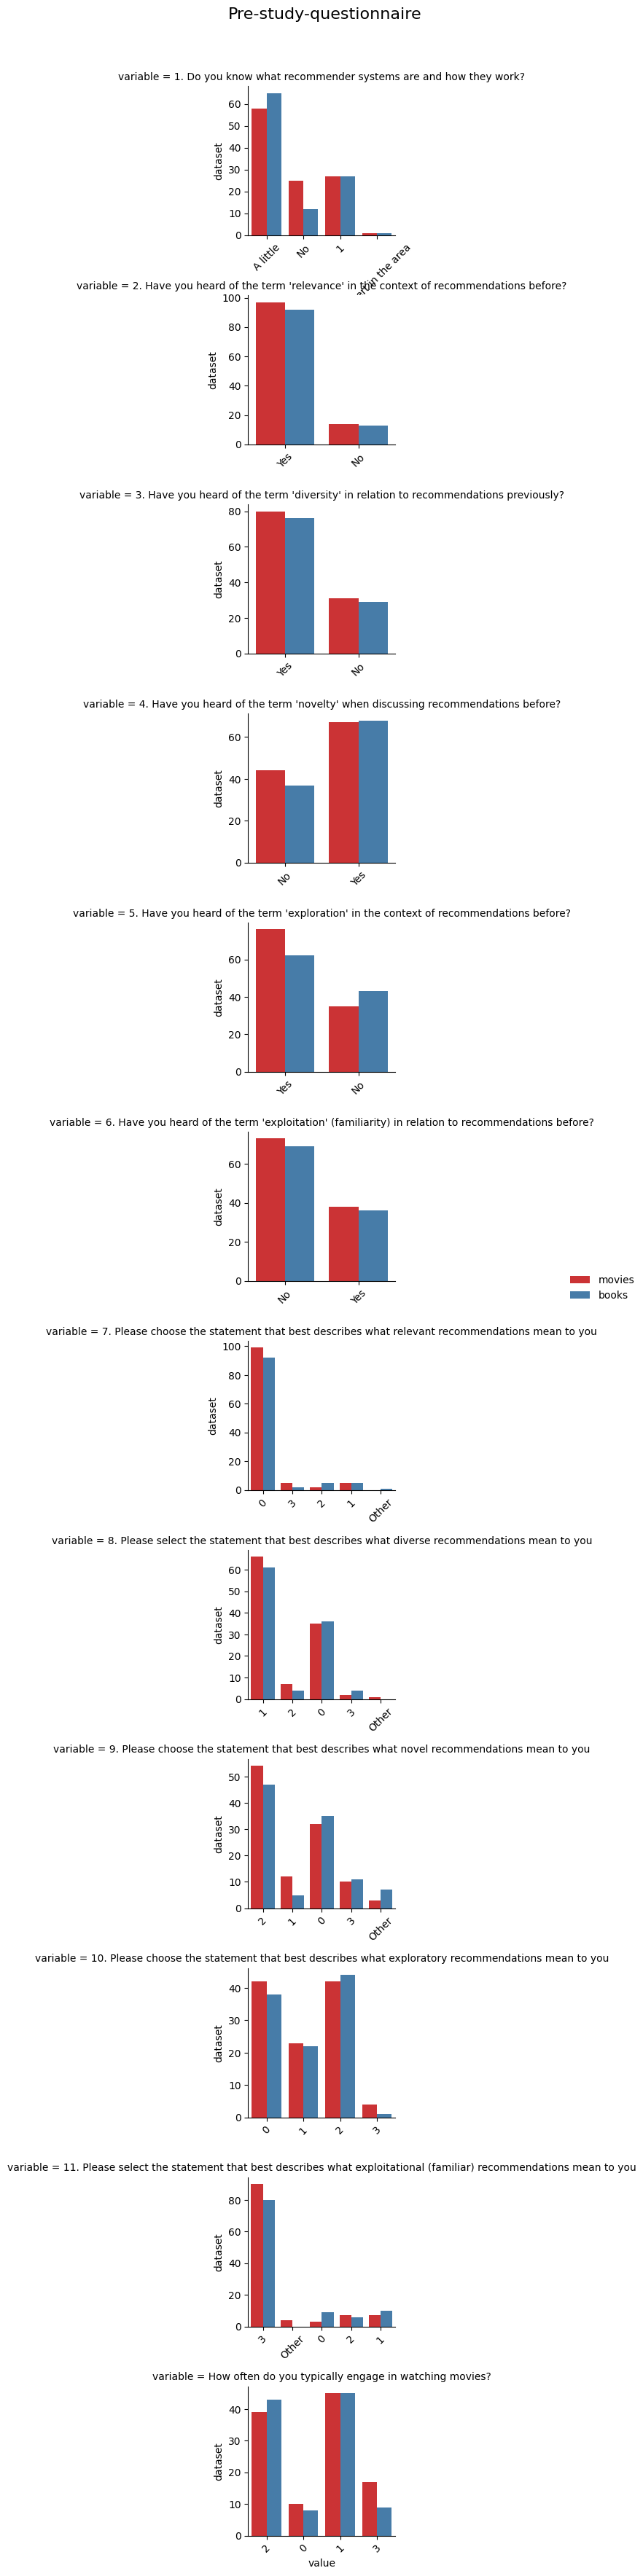

In [5]:
plot_q(pre_study_q, "Pre-study-questionnaire", pre_study_questions, pre_study_answer_mapping, map_questions=True, wrap=1)

In [6]:
def plot_corr(q_df, q_title, ignore_qs=True, figsize=(16, 10)):
    dfic = q_df.loc[:, [q_name for q_name in q_df.columns if q_name.startswith("q") and (not q_name.startswith("qs") or not ignore_qs)]]
    corr = dfic.corr()
    
    fix,ax = plt.subplots(1,1, figsize=figsize)
    plt.title(q_title)
    sns.heatmap(corr, vmin=-1, vmax=1, annot=True, fmt=".2f", cmap="RdBu")

/tmp/ipykernel_364449/3622799956.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = dfic.corr()


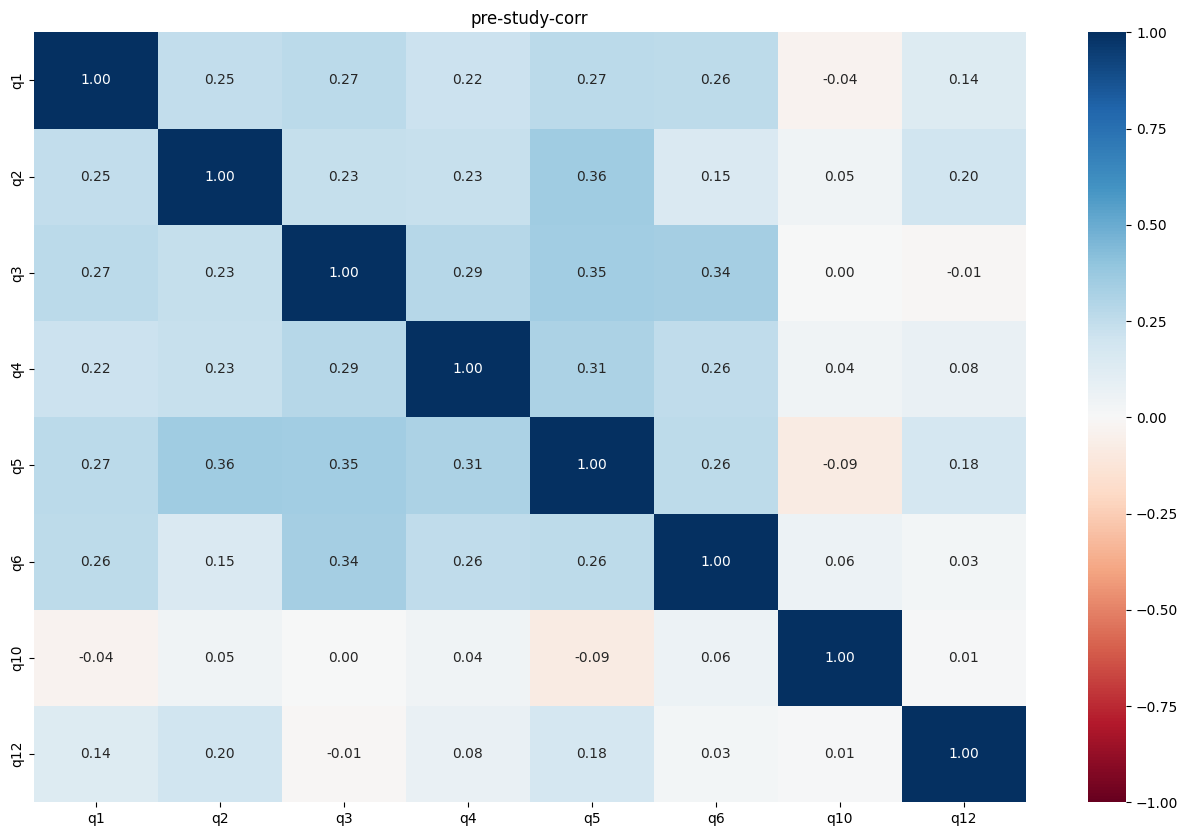

In [7]:
plot_corr(pre_study_q, "pre-study-corr")

# Metric assessment analysis (select single most diverse list)

In [8]:
selected_metrics = pd.read_csv("./inputs/selected_metrics.csv")

In [9]:
assessment_metric_comparison = pd.read_csv("./inputs/assessment_metric_comparison.csv")

In [12]:
assessment_metric_comparison[["source_metric", 'target_metric', 'target_value', 'was_selected']].groupby(["source_metric", 'target_metric']).mean('target_value')

target_value  was_selected
source_metric target_metric                               
BIN-DIV       bin_div               0.615707      0.467593
              cb_ild                0.508286      0.467593
              cf_ild                0.698979      0.467593
              ease_ild              0.967930      0.467593
              genres                0.758912      0.467593
              relevance             0.435546      0.467593
              relevance_normed      0.998912      0.467593
              tags                  0.410199      0.467593
CB-ILD        bin_div               0.403258      0.333333
              cb_ild                0.596624      0.333333
              cf_ild                0.708693      0.333333
              ease_ild              0.968270      0.333333
              genres                0.701003      0.333333
              relevance             0.423761      0.333333
              relevance_normed      0.998856      0.333333
              tags                  0.399023      0.333333
CF-ILD        bin_div               0.372206      0.199074
              cb_ild                0.501809      0.199074
              cf_ild                0.760299      0.199074
              ease_ild              0.973266      0.199074
              genres                0.688219      0.199074
              relevance             0.461378      0.199074
              relevance_normed      0.999060      0.199074
              tags                  0.363072      0.199074

In [13]:
assessment_metric_comparison.groupby(["source_metric"]).mean('target_value')

,participation,target_value,was_selected
source_metric,,,
BIN-DIV,196.162037,0.674309,0.467593
CB-ILD,196.162037,0.649936,0.333333
CF-ILD,196.162037,0.639913,0.199074


### Pairwise comparison for metrics in assessment

In [14]:
rl = assessment_metric_comparison.loc[assessment_metric_comparison.target_metric=="relevance"]
rl.groupby("source_metric").mean()

/tmp/ipykernel_364449/258263295.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rl.groupby("source_metric").mean()


,participation,target_value,was_selected
source_metric,,,
BIN-DIV,196.162037,0.435546,0.467593
CB-ILD,196.162037,0.423761,0.333333
CF-ILD,196.162037,0.461378,0.199074


In [15]:
pairwiseData = []

for dt in assessment_metric_comparison.dataset.unique():
    d_dt = assessment_metric_comparison.loc[assessment_metric_comparison.dataset == dt]
    for p in assessment_metric_comparison.participation.unique():
        d_dt_p = d_dt.loc[d_dt.participation == p]
        for m in assessment_metric_comparison.target_metric.unique():
            d_dt_p_m = d_dt_p.loc[d_dt_p.target_metric == m]
            selected = d_dt_p_m.loc[d_dt_p_m.was_selected == 1]
            if len(selected)>0:
                #print(selected.shape)
                selected = selected.iloc[-1,:]
                not_selected = d_dt_p_m.loc[d_dt_p_m.was_selected == 0]
                for i, ns in not_selected.iterrows():
                    if m == "relevance_normed":
                        conc = selected["target_value"]<ns["target_value"]
                    else:
                        conc = selected["target_value"]>ns["target_value"]
                    record = {"dataset":dt,
                             "participation":p,
                             "metric":m,
                             "v_selected":selected["target_value"],
                             "v_not_selected":ns["target_value"],
                             "concordant": conc}
                    pairwiseData.append(record)

            
dfAssesmentPairwise = pd.DataFrame(pairwiseData)
dfAssesmentPairwise


,dataset,participation,metric,v_selected,v_not_selected,concordant
0,movies,63,cf_ild,0.558643,0.561597,False
1,movies,63,cf_ild,0.558643,0.504585,True
2,movies,63,cb_ild,0.465328,0.430423,True
3,movies,63,cb_ild,0.465328,0.546928,False
4,movies,63,ease_ild,0.986438,0.977677,True
...,...,...,...,...,...,...
3451,books,336,bin_div,0.391782,0.387807,True
3452,books,336,relevance,0.184419,0.215091,False
3453,books,336,relevance,0.184419,0.160992,True
3454,books,336,relevance_normed,0.998092,0.999116,True


#### Table 1

In [16]:
dfAssesmentPairwise.groupby("metric")[["concordant"]].mean().round(2)

,concordant
metric,
bin_div,0.60
cb_ild,0.50
cf_ild,0.45
ease_ild,0.51
genres,0.61
relevance,0.36
relevance_normed,0.61
tags,0.58


In [17]:
dfAssesmentPairwise.groupby(["dataset","metric"])[["concordant"]].mean().round(2)

concordant
dataset metric                      
books   bin_div                 0.59
        cb_ild                  0.50
        cf_ild                  0.47
        ease_ild                0.50
        genres                  0.58
        relevance               0.33
        relevance_normed        0.65
        tags                    0.60
movies  bin_div                 0.61
        cb_ild                  0.49
        cf_ild                  0.44
        ease_ild                0.53
        genres                  0.64
        relevance               0.38
        relevance_normed        0.58
        tags                    0.56

### Corresponding significance analysis

#### Overall data

In [18]:
posDt = pd.crosstab(dfAssesmentPairwise.participation, dfAssesmentPairwise.metric, values=dfAssesmentPairwise.concordant, aggfunc=sum).sum()
allDt = pd.crosstab(dfAssesmentPairwise.participation, dfAssesmentPairwise.metric, values=dfAssesmentPairwise.concordant, aggfunc=len).sum()
negDt = allDt - posDt
crossTab = pd.DataFrame([posDt, negDt]).T
crossTab = crossTab.drop("relevance")
crossTab

,0,1
metric,,
bin_div,260,172
cb_ild,215,217
cf_ild,196,236
ease_ild,221,211
genres,264,168
relevance_normed,265,167
tags,251,181


In [19]:
from scipy.stats import chi2_contingency
chi2_contingency(crossTab)

Chi2ContingencyResult(statistic=43.40134764021404, pvalue=9.714189172487241e-08, dof=6, expected_freq=array([[238.85714286, 193.14285714],
       [238.85714286, 193.14285714],
       [238.85714286, 193.14285714],
       [238.85714286, 193.14285714],
       [238.85714286, 193.14285714],
       [238.85714286, 193.14285714],
       [238.85714286, 193.14285714]]))

#### Books

In [20]:
d = dfAssesmentPairwise.loc[dfAssesmentPairwise.dataset=="books"]
posDt = pd.crosstab(d.participation, d.metric, values=d.concordant, aggfunc=sum).sum()
allDt = pd.crosstab(d.participation, d.metric, values=d.concordant, aggfunc=len).sum()
negDt = allDt - posDt
crossTab = pd.DataFrame([posDt, negDt]).T
crossTab = crossTab.drop("relevance")
crossTab

,0,1
metric,,
bin_div,124,86
cb_ild,106,104
cf_ild,98,112
ease_ild,104,106
genres,121,89
relevance_normed,137,73
tags,127,83


In [21]:
chi2_contingency(crossTab)

Chi2ContingencyResult(statistic=23.442805168125272, pvalue=0.0006609595113665123, dof=6, expected_freq=array([[116.71428571,  93.28571429],
       [116.71428571,  93.28571429],
       [116.71428571,  93.28571429],
       [116.71428571,  93.28571429],
       [116.71428571,  93.28571429],
       [116.71428571,  93.28571429],
       [116.71428571,  93.28571429]]))

#### Movies

In [22]:
d = dfAssesmentPairwise.loc[dfAssesmentPairwise.dataset=="movies"]
posDt = pd.crosstab(d.participation, d.metric, values=d.concordant, aggfunc=sum).sum()
allDt = pd.crosstab(d.participation, d.metric, values=d.concordant, aggfunc=len).sum()
negDt = allDt - posDt
crossTab = pd.DataFrame([posDt, negDt]).T
crossTab = crossTab.drop("relevance")
crossTab

,0,1
metric,,
bin_div,136,86
cb_ild,109,113
cf_ild,98,124
ease_ild,117,105
genres,143,79
relevance_normed,128,94
tags,124,98


In [23]:
chi2_contingency(crossTab)

Chi2ContingencyResult(statistic=26.334884421353816, pvalue=0.00019282518677067608, dof=6, expected_freq=array([[122.14285714,  99.85714286],
       [122.14285714,  99.85714286],
       [122.14285714,  99.85714286],
       [122.14285714,  99.85714286],
       [122.14285714,  99.85714286],
       [122.14285714,  99.85714286],
       [122.14285714,  99.85714286]]))

In [24]:
assessment_metric_comparison.groupby(['dataset', 'was_selected', 'target_metric']).mean()

/tmp/ipykernel_364449/2447686447.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  assessment_metric_comparison.groupby(['dataset', 'was_selected', 'target_metric']).mean()


participation  target_value
dataset was_selected target_metric                                
books   0            bin_div              270.809524      0.383431
                     cb_ild               270.809524      0.539178
                     cf_ild               270.809524      0.873644
                     ease_ild             270.809524      0.962670
                     genres               270.809524      0.688873
                     relevance            270.809524      0.226676
                     relevance_normed     270.809524      0.998618
                     tags                 270.809524      0.426457
        1            bin_div              270.809524      0.432558
                     cb_ild               270.809524      0.540131
                     cf_ild               270.809524      0.871579
                     ease_ild             270.809524      0.963752
                     genres               270.809524      0.708552
                     relevance            270.809524      0.215333
                     relevance_normed     270.809524      0.998481
                     tags                 270.809524      0.437311
movies  0            bin_div              125.549550      0.495040
                     cb_ild               125.549550      0.531628
                     cf_ild               125.549550      0.585696
                     ease_ild             125.549550      0.976332
                     genres               125.549550      0.725722
                     relevance            125.549550      0.651268
                     relevance_normed     125.549550      0.999304
                     tags                 125.549550      0.346498
        1            bin_div              125.549550      0.582477
                     cb_ild               125.549550      0.532330
                     cf_ild               125.549550      0.570058
                     ease_ild             125.549550      0.976074
                     genres               125.549550      0.755184
                     relevance            125.549550      0.634905
                     relevance_normed     125.549550      0.999269
                     tags                 125.549550      0.367741

### Table 1 results continued

In [25]:
# These are metrics actually SELECTED by the users
selected_metrics.selected_metric.value_counts()

BIN-DIV    101
CB-ILD      72
CF-ILD      43
Name: selected_metric, dtype: int64

In [26]:
# THese are metrics that were actually USED IN DIVERSIFICATION
selected_metrics.compare_alphas_metric.value_counts()

BIN-DIV    72
CF-ILD     72
CB-ILD     72
Name: compare_alphas_metric, dtype: int64

In [27]:
selected_metrics.groupby(['selected_metric', 'dataset']).count()

participation  compare_alphas_metric  BIN-DIV  \
selected_metric dataset                                                  
BIN-DIV         books               46                     46       46   
                movies              55                     55       55   
CB-ILD          books               36                     36       36   
                movies              36                     36       36   
CF-ILD          books               23                     23       23   
                movies              20                     20       20   

                         CF-ILD  CB-ILD  
selected_metric dataset                  
BIN-DIV         books        46      46  
                movies       55      55  
CB-ILD          books        36      36  
                movies       36      36  
CF-ILD          books        23      23  
                movies       20      20

In [28]:
selected_metrics.groupby(['compare_alphas_metric', 'dataset']).count()

participation  selected_metric  BIN-DIV  \
compare_alphas_metric dataset                                            
BIN-DIV               books               37               37       37   
                      movies              35               35       35   
CB-ILD                books               32               32       32   
                      movies              40               40       40   
CF-ILD                books               36               36       36   
                      movies              36               36       36   

                               CF-ILD  CB-ILD  
compare_alphas_metric dataset                  
BIN-DIV               books        37      37  
                      movies       35      35  
CB-ILD                books        32      32  
                      movies       40      40  
CF-ILD                books        36      36  
                      movies       36      36

[Text(0.5, 1.0, 'Metrics selected by users')]

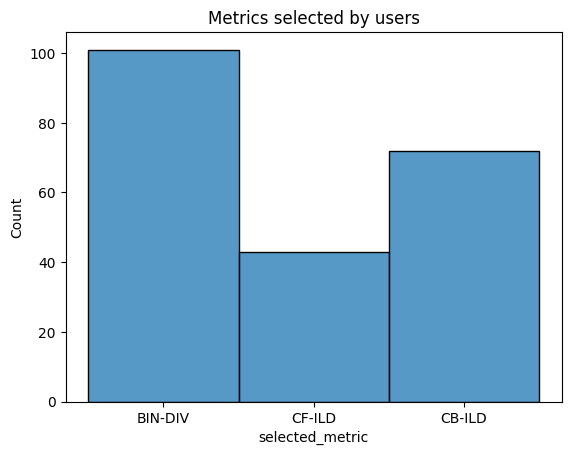

In [29]:
g = sns.histplot(selected_metrics, x="selected_metric")
g.set(title="Metrics selected by users")

[Text(0.5, 1.0, 'Metrics selected by users')]

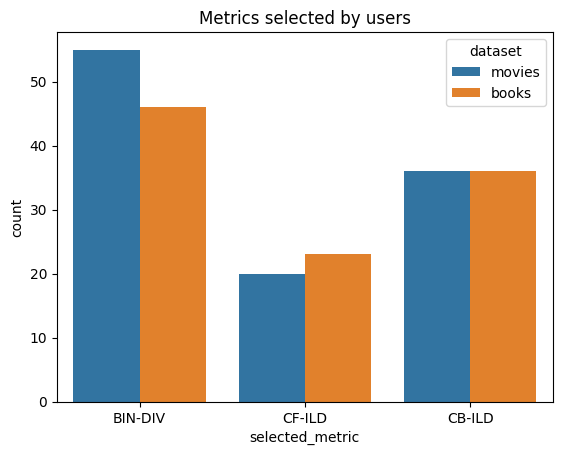

In [39]:
g = sns.countplot(selected_metrics, x="selected_metric", hue="dataset", dodge=True)
g.set(title="Metrics selected by users")

#### Significance analysis for the selection

In [31]:
def bin_assignment(selected_metrics):
    selected_metrics['BIN-DIV'] = 0
    selected_metrics['CF-ILD'] = 0
    selected_metrics['CB-ILD'] = 0

    selected_metrics.loc[selected_metrics.selected_metric == 'BIN-DIV','BIN-DIV'] = 1
    selected_metrics.loc[selected_metrics.selected_metric == 'CF-ILD','CF-ILD'] = 1
    selected_metrics.loc[selected_metrics.selected_metric == 'CB-ILD','CB-ILD'] = 1
    
    
def create_crosstab(selected_metrics):
    crossTab = [[selected_metrics["BIN-DIV"].sum(),selected_metrics["BIN-DIV"].count()-selected_metrics["BIN-DIV"].sum()],
               [selected_metrics["CF-ILD"].sum(),selected_metrics["CF-ILD"].count()-selected_metrics["CF-ILD"].sum()],
               [selected_metrics["CB-ILD"].sum(),selected_metrics["CB-ILD"].count()-selected_metrics["CB-ILD"].sum()]]
    return crossTab

In [32]:
#transform data into suitable format
bin_assignment(selected_metrics)

In [33]:
# test for all data
crossTab = create_crosstab(selected_metrics)
from scipy.stats import chi2_contingency
chi2_contingency(crossTab)

Chi2ContingencyResult(statistic=35.041666666666664, pvalue=2.4592278304734448e-08, dof=2, expected_freq=array([[ 72., 144.],
       [ 72., 144.],
       [ 72., 144.]]))

In [34]:
print(chi2_contingency(crossTab[0:2]))
print(chi2_contingency(crossTab[1:3]))
print(chi2_contingency(crossTab[0::2]))

Chi2ContingencyResult(statistic=33.84375, pvalue=5.972063885729782e-09, dof=1, expected_freq=array([[ 72., 144.],
       [ 72., 144.]]))
Chi2ContingencyResult(statistic=9.290577424221642, pvalue=0.0023033554506655543, dof=1, expected_freq=array([[ 57.5, 158.5],
       [ 57.5, 158.5]]))
Chi2ContingencyResult(statistic=7.558818934541479, pvalue=0.005971711525420041, dof=1, expected_freq=array([[ 86.5, 129.5],
       [ 86.5, 129.5]]))


In [35]:
# test for books only
crossTab = create_crosstab(selected_metrics.loc[selected_metrics.dataset=="books"])
from scipy.stats import chi2_contingency
chi2_contingency(crossTab)

Chi2ContingencyResult(statistic=11.4, pvalue=0.0033459654574712716, dof=2, expected_freq=array([[35., 70.],
       [35., 70.],
       [35., 70.]]))

In [36]:
print(chi2_contingency(crossTab[0:2]))
print(chi2_contingency(crossTab[1:3]))
print(chi2_contingency(crossTab[0::2]))

Chi2ContingencyResult(statistic=10.447116867098366, pvalue=0.0012284104451646988, dof=1, expected_freq=array([[34.5, 70.5],
       [34.5, 70.5]]))
Chi2ContingencyResult(statistic=3.3943203502076553, pvalue=0.06542131931990229, dof=1, expected_freq=array([[29.5, 75.5],
       [29.5, 75.5]]))
Chi2ContingencyResult(statistic=1.6206173780487805, pvalue=0.20300572451118, dof=1, expected_freq=array([[41., 64.],
       [41., 64.]]))


In [37]:
# test for movies only
crossTab = create_crosstab(selected_metrics.loc[selected_metrics.dataset=="movies"])
from scipy.stats import chi2_contingency
chi2_contingency(crossTab)

Chi2ContingencyResult(statistic=24.891891891891888, pvalue=3.933637664017722e-06, dof=2, expected_freq=array([[37., 74.],
       [37., 74.],
       [37., 74.]]))

In [38]:
print(chi2_contingency(crossTab[0:2]))
print(chi2_contingency(crossTab[1:3]))
print(chi2_contingency(crossTab[0::2]))

Chi2ContingencyResult(statistic=23.27727891156463, pvalue=1.4024705177688757e-06, dof=1, expected_freq=array([[37.5, 73.5],
       [37.5, 73.5]]))
Chi2ContingencyResult(statistic=5.373278829604131, pvalue=0.02044750607910771, dof=1, expected_freq=array([[28., 83.],
       [28., 83.]]))
Chi2ContingencyResult(statistic=6.033722003187652, pvalue=0.014035108178767066, dof=1, expected_freq=array([[45.5, 65.5],
       [45.5, 65.5]]))


- significant differences for all data, movies and books. Overall, the relation is binDiv > CB > CF, for movies, but only  binDiv > CF can be shown for books

# Compare-alphas analysis (different diversification thresholds, order the lists by drag&drop)

In [40]:
df_alphas_started = pd.read_csv("./inputs/df_alphas_started.csv")

In [77]:
df_alphas_ended = pd.read_csv("./inputs/df_alphas_ended.csv")

In [78]:
import ast
metric_names = ['cf_ild', 'cb_ild', 'ease_ild', 'genres', 'bin_div', 'tags']
# Deserialize lists that got serialized as strings
for list_col_name in ['alphas', 'approx_alphas', 'gold', 'selected'] + metric_names + ['relevance', 'relevance_normed']:
    df_alphas_ended[list_col_name] = df_alphas_ended[list_col_name].apply(ast.literal_eval)

## Absolute judgment comparison: 
- does positioning on the scale correspond with the diversity values?

In [79]:
df_alphas_ended_books = df_alphas_ended.loc[df_alphas_ended.dataset=="books"]
df_alphas_ended_movies = df_alphas_ended.loc[df_alphas_ended.dataset=="movies"]

In [80]:
def get_dfCompareAlpha(df_alphas_ended):
    alphaLists = []
    for i, row in df_alphas_ended.iterrows():
        for i, alpha in enumerate(row.alphas):
            est_alpha = row.approx_alphas[i]
            metric_values = [
                row[metric_name][i] for metric_name in metric_names + ['relevance', 'relevance_normed']
            ]
            
            alphaLists.append([alpha,est_alpha] + metric_values)

    dfCompareAlpha = pd.DataFrame(alphaLists)
    dfCompareAlpha.columns = ["trueAlpha","estimatedAlpha"] + metric_names + ["relevance", 'relevance_normed']
    dfCompareAlpha["trueAlphaStr"] = dfCompareAlpha["trueAlpha"].astype(str)
    dfCompareAlpha = dfCompareAlpha.sort_values("trueAlpha")
    return dfCompareAlpha

### Table 2

In [81]:
v = ["all","books","movies"]
for i,d in enumerate([df_alphas_ended,df_alphas_ended_books,df_alphas_ended_movies]): 
    print(v[i])
    
    for m in df_alphas_ended.compare_alphas_metric.unique():  
        print(m)
        dtr = d.loc[d.compare_alphas_metric == m]
        print(dtr.shape)
        dfCorr = get_dfCompareAlpha(dtr)
        print(dfCorr.corr(numeric_only=True).round(2).iloc[1,0])


all
BIN-DIV
(144, 38)
0.18
CF-ILD
(144, 38)
0.3
CB-ILD
(144, 38)
0.27
books
BIN-DIV
(74, 38)
0.11
CF-ILD
(72, 38)
0.35
CB-ILD
(64, 38)
0.27
movies
BIN-DIV
(70, 38)
0.26
CF-ILD
(72, 38)
0.25
CB-ILD
(80, 38)
0.27


In [82]:
dfca_full = get_dfCompareAlpha(df_alphas_ended)
dfca_full.corr(numeric_only=True)

,trueAlpha,estimatedAlpha,cf_ild,cb_ild,ease_ild,genres,bin_div,tags,relevance,relevance_normed
trueAlpha,1.000000,0.247607,0.554948,0.458238,0.439942,0.607033,0.554199,-0.124607,-0.360183,-0.616888
estimatedAlpha,0.247607,1.000000,0.154779,0.170344,0.179250,0.239716,0.227097,-0.017379,-0.078495,-0.156441
cf_ild,0.554948,0.154779,1.000000,0.229942,0.349621,0.338602,0.181863,-0.031032,-0.454966,-0.520077
cb_ild,0.458238,0.170344,0.229942,1.000000,0.352286,0.266430,0.087611,-0.005635,-0.131773,-0.246211
ease_ild,0.439942,0.179250,0.349621,0.352286,1.000000,0.510153,0.381841,-0.041781,0.038951,-0.335015
genres,0.607033,0.239716,0.338602,0.266430,0.510153,1.000000,0.771636,0.055559,-0.143490,-0.369479
bin_div,0.554199,0.227097,0.181863,0.087611,0.381841,0.771636,1.000000,0.064860,-0.090772,-0.227128
tags,-0.124607,-0.017379,-0.031032,-0.005635,-0.041781,0.055559,0.064860,1.000000,-0.022048,0.357746
relevance,-0.360183,-0.078495,-0.454966,-0.131773,0.038951,-0.143490,-0.090772,-0.022048,1.000000,0.276599
relevance_normed,-0.616888,-0.156441,-0.520077,-0.246211,-0.335015,-0.369479,-0.227128,0.357746,0.276599,1.000000


In [83]:
dfca_books = get_dfCompareAlpha(df_alphas_ended_books)
dfca_books.corr(numeric_only=True)

,trueAlpha,estimatedAlpha,cf_ild,cb_ild,ease_ild,genres,bin_div,tags,relevance,relevance_normed
trueAlpha,1.000000,0.236352,0.494784,0.435029,0.496185,0.693169,0.767380,0.448046,-0.612606,-0.536495
estimatedAlpha,0.236352,1.000000,0.251146,0.167869,0.235151,0.288431,0.270874,0.227275,-0.271178,-0.178713
cf_ild,0.494784,0.251146,1.000000,0.390064,0.877921,0.717316,0.551192,0.706304,-0.523612,-0.481808
cb_ild,0.435029,0.167869,0.390064,1.000000,0.398150,0.382154,0.332969,0.275707,-0.391877,-0.280836
ease_ild,0.496185,0.235151,0.877921,0.398150,1.000000,0.680503,0.573942,0.650750,-0.411468,-0.400840
genres,0.693169,0.288431,0.717316,0.382154,0.680503,1.000000,0.850417,0.653810,-0.566259,-0.476338
bin_div,0.767380,0.270874,0.551192,0.332969,0.573942,0.850417,1.000000,0.520365,-0.540191,-0.382579
tags,0.448046,0.227275,0.706304,0.275707,0.650750,0.653810,0.520365,1.000000,-0.378777,-0.563544
relevance,-0.612606,-0.271178,-0.523612,-0.391877,-0.411468,-0.566259,-0.540191,-0.378777,1.000000,0.471206
relevance_normed,-0.536495,-0.178713,-0.481808,-0.280836,-0.400840,-0.476338,-0.382579,-0.563544,0.471206,1.000000


In [84]:
dfca_movies = get_dfCompareAlpha(df_alphas_ended_movies)
dfca_movies.corr(numeric_only=True)

,trueAlpha,estimatedAlpha,cf_ild,cb_ild,ease_ild,genres,bin_div,tags,relevance,relevance_normed
trueAlpha,1.000000,0.259422,0.782011,0.482205,0.404555,0.519417,0.388906,-0.437104,-0.429623,-0.698303
estimatedAlpha,0.259422,1.000000,0.205850,0.169964,0.104463,0.180430,0.186739,-0.093327,-0.089070,-0.135907
cf_ild,0.782011,0.205850,1.000000,0.282833,0.478655,0.381195,0.199224,-0.718237,-0.329356,-0.806723
cb_ild,0.482205,0.169964,0.282833,1.000000,0.299847,0.131288,-0.123869,-0.088651,-0.149336,-0.218939
ease_ild,0.404555,0.104463,0.478655,0.299847,1.000000,0.262697,0.171125,-0.181472,0.029342,-0.255342
genres,0.519417,0.180430,0.381195,0.131288,0.262697,1.000000,0.710045,-0.124922,-0.163072,-0.280218
bin_div,0.388906,0.186739,0.199224,-0.123869,0.171125,0.710045,1.000000,0.028706,-0.099407,-0.110125
tags,-0.437104,-0.093327,-0.718237,-0.088651,-0.181472,-0.124922,0.028706,1.000000,0.291543,0.655447
relevance,-0.429623,-0.089070,-0.329356,-0.149336,0.029342,-0.163072,-0.099407,0.291543,1.000000,0.378996
relevance_normed,-0.698303,-0.135907,-0.806723,-0.218939,-0.255342,-0.280218,-0.110125,0.655447,0.378996,1.000000


- in all cases, there is a good correlation between alpha values and individual diversity metrics overall
- estimated alpha best correlates with true alpha, much less so with the individual diversification metrics -> task-wise dependencies?
- mild correlation in between differend diversity metrics -> indeed highly diverse diversities:-)

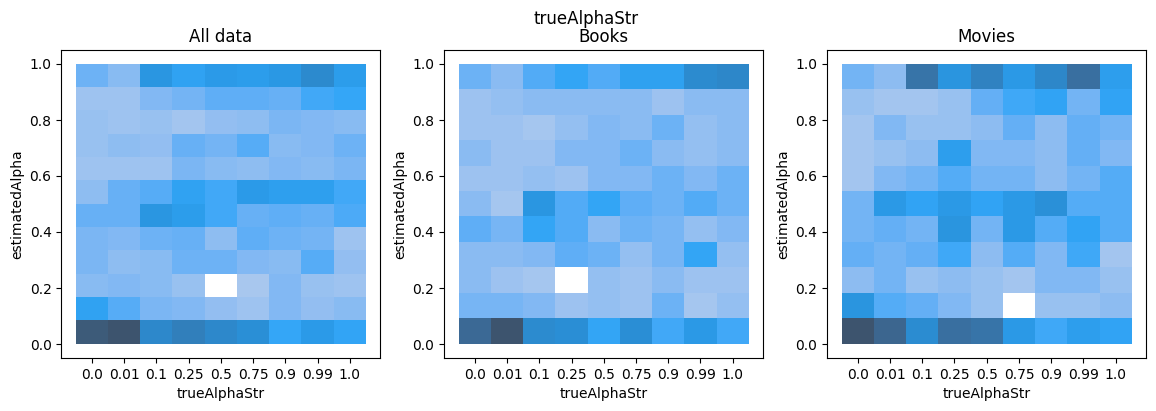

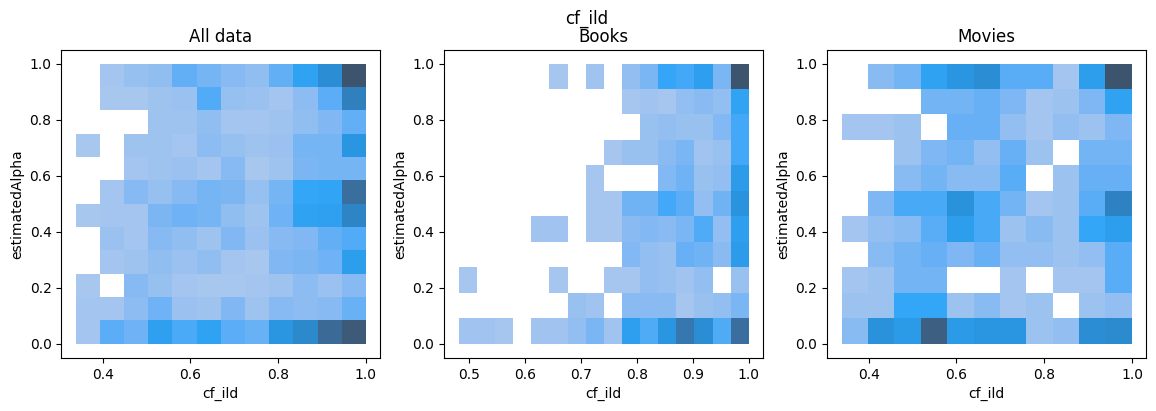

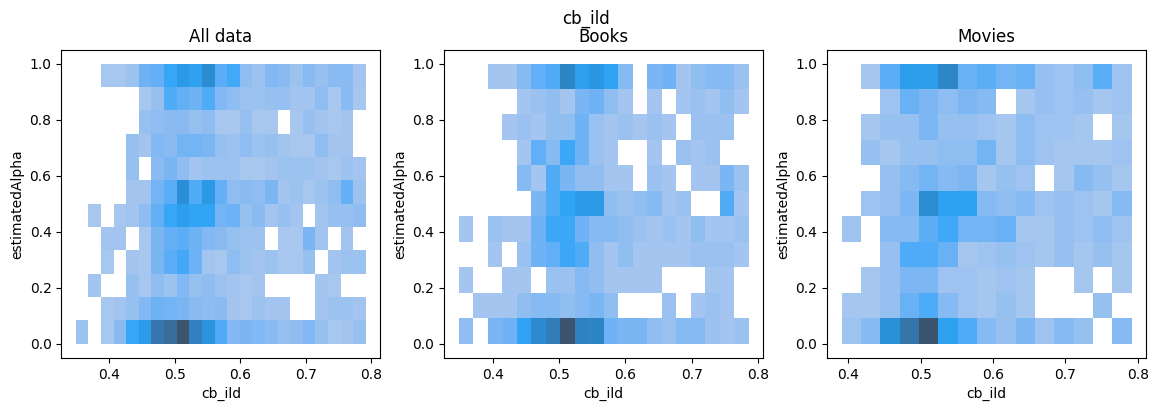

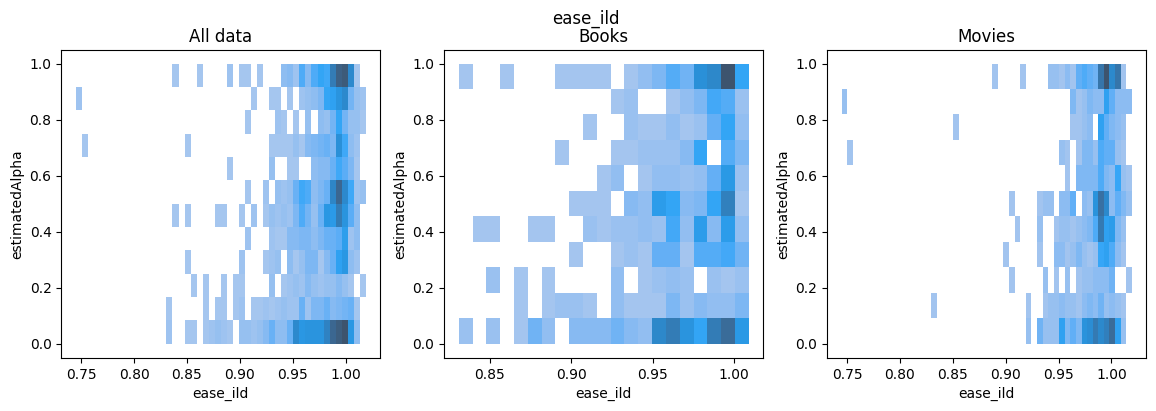

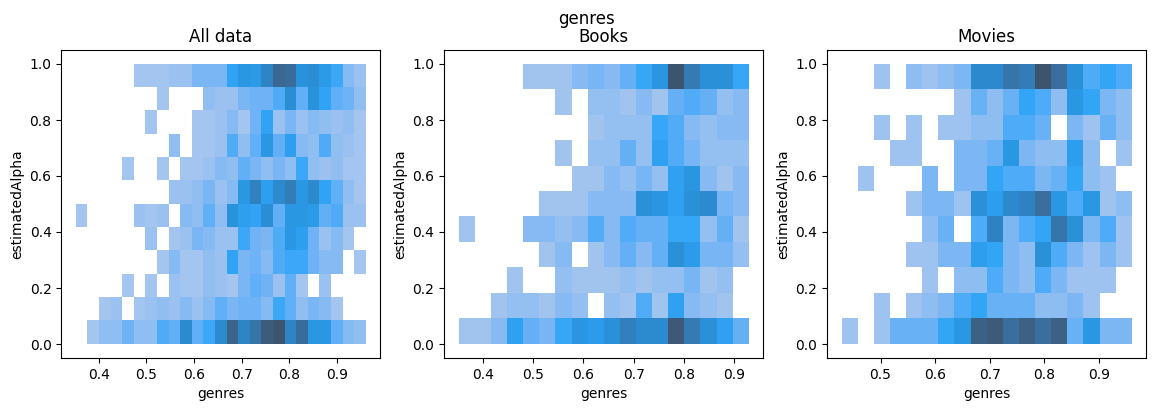

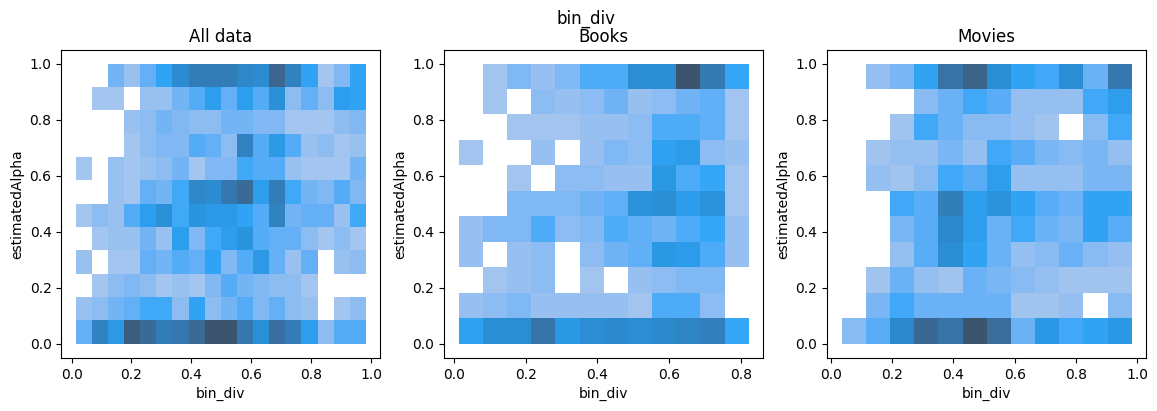

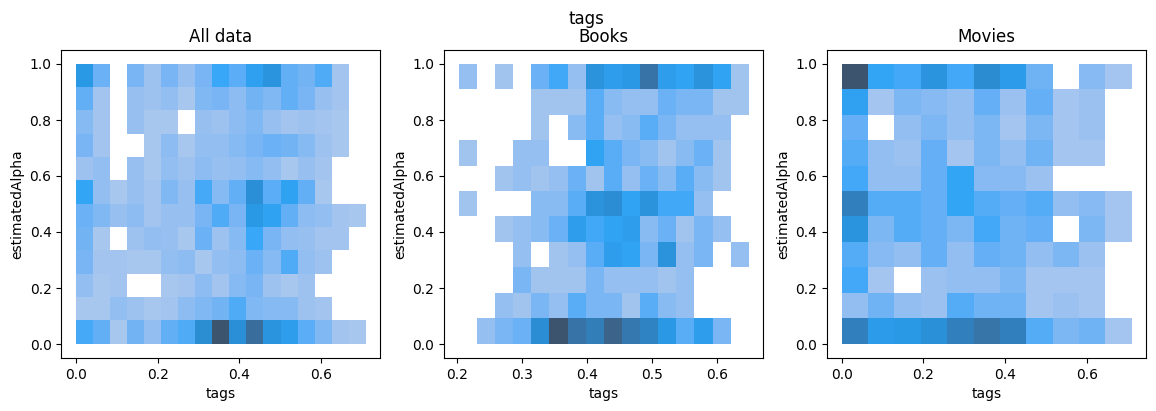

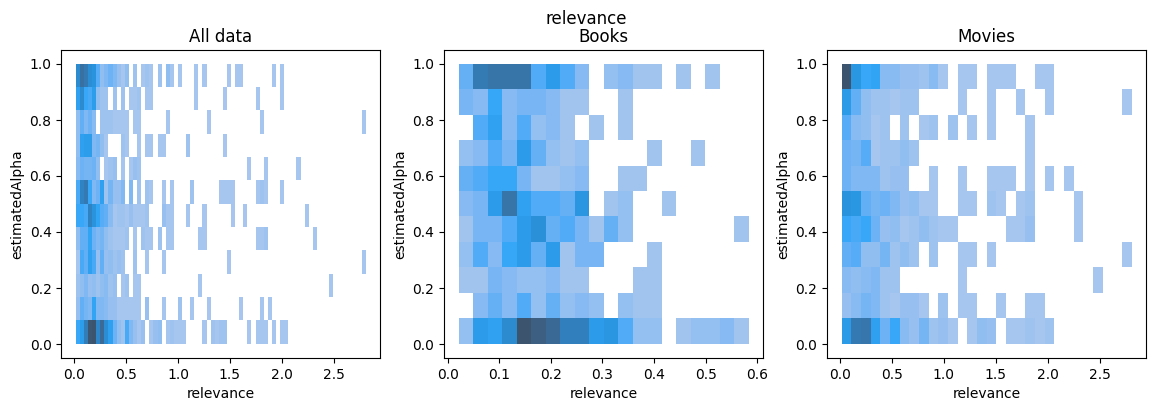

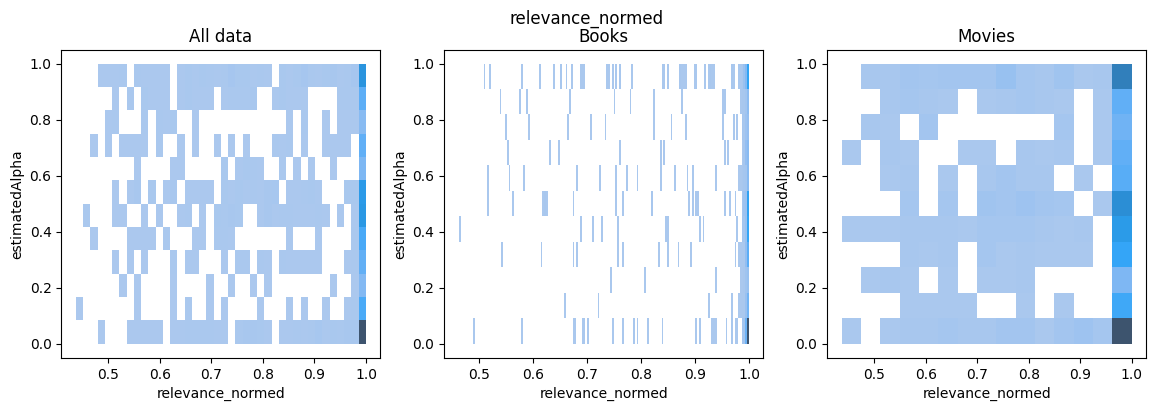

In [85]:
for f in ["trueAlphaStr"]  + metric_names + ["relevance", "relevance_normed"]:    
    fig, ax = plt.subplots(1,3, figsize=(14,4))
    sns.histplot(dfca_full, x=f, y="estimatedAlpha", ax=ax[0])
    sns.histplot(dfca_books, x=f, y="estimatedAlpha", ax=ax[1])
    sns.histplot(dfca_movies, x=f, y="estimatedAlpha", ax=ax[2])
    ax[0].set_title("All data")
    ax[1].set_title("Books")
    ax[2].set_title("Movies")
    fig.suptitle(f)
    plt.show()

## Pairwise magnitude difference estimation:
- while comparing pairs of lists, does the distance on axes correspond to distances w.r.t. alphas or metrics?

In [86]:
def get_dfCompareAlphaPairs(df_alphas_ended):
    alphaLists = []
    for i, row in df_alphas_ended.iterrows():
            for i,alpha1 in enumerate(row.alphas):
                for j,alpha2 in enumerate(row.alphas):
                    if i<j:  
                        alpha = alpha1-alpha2
                        est_alpha = row.approx_alphas[i] - row.approx_alphas[j]
                        metric_deltas = [row[metric_name][i] - row[metric_name][j] for metric_name in metric_names]
                        RELEVANCE = row["relevance"][j] - row["relevance"][i]
                        RELEVANCE_NORMED = row["relevance_normed"][j] - row["relevance_normed"][i]
                        alphaLists.append([alpha,est_alpha] + metric_deltas + [RELEVANCE, RELEVANCE_NORMED])

    dfCompareAlpha = pd.DataFrame(alphaLists)
    dfCompareAlpha.columns = ["trueAlpha","estimatedAlpha"] + metric_names + ["relevance", "relevance_normed"]
    dfCompareAlpha["trueAlphaStr"] = dfCompareAlpha["trueAlpha"].astype(str)
    dfCompareAlpha = dfCompareAlpha.sort_values("trueAlpha")
    return dfCompareAlpha

### Table 2 (Middle)

In [87]:
v = ["all","books","movies"]
for i,d in enumerate([df_alphas_ended,df_alphas_ended_books,df_alphas_ended_movies]): 
    print(v[i])    
    for m in df_alphas_ended.compare_alphas_metric.unique():  
        print(m)
        dtr = d.loc[d.compare_alphas_metric == m]
        dfCorr = get_dfCompareAlphaPairs(dtr)
        print(dfCorr.corr(numeric_only=True).round(2).iloc[1,0])



all
BIN-DIV
0.21
CF-ILD
0.36
CB-ILD
0.32
books
BIN-DIV
0.15
CF-ILD
0.41
CB-ILD
0.35
movies
BIN-DIV
0.28
CF-ILD
0.31
CB-ILD
0.3


### Table 4

In [90]:
d = get_dfCompareAlphaPairs(df_alphas_ended)
res = d.corr(numeric_only=True)[["estimatedAlpha"]].T
res = res[["cf_ild","ease_ild","tags","genres","bin_div","cb_ild","relevance_normed"]]
res.round(2).to_latex()

/tmp/ipykernel_364449/2089175903.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  res.round(2).to_latex()


'\\begin{tabular}{lrrrrrrr}\n\\toprule\n{} &  cf\\_ild &  ease\\_ild &  tags &  genres &  bin\\_div &  cb\\_ild &  relevance\\_normed \\\\\n\\midrule\nestimatedAlpha &    0.28 &      0.26 &   0.0 &    0.32 &     0.33 &    0.28 &              0.21 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [91]:
d = get_dfCompareAlphaPairs(df_alphas_ended_books)
res = d.corr(numeric_only=True)[["estimatedAlpha"]].T
res = res[["cf_ild","ease_ild","tags","genres","bin_div","cb_ild","relevance_normed"]]
res.round(2).to_latex()

/tmp/ipykernel_364449/3745597335.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  res.round(2).to_latex()


'\\begin{tabular}{lrrrrrrr}\n\\toprule\n{} &  cf\\_ild &  ease\\_ild &  tags &  genres &  bin\\_div &  cb\\_ild &  relevance\\_normed \\\\\n\\midrule\nestimatedAlpha &    0.39 &      0.36 &  0.38 &    0.41 &     0.38 &    0.28 &              0.26 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [92]:
d = get_dfCompareAlphaPairs(df_alphas_ended_movies)
res = d.corr(numeric_only=True)[["estimatedAlpha"]].T
res = res[["cf_ild","ease_ild","tags","genres","bin_div","cb_ild","relevance_normed"]]
res.round(2).to_latex()

/tmp/ipykernel_364449/2720399207.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  res.round(2).to_latex()


'\\begin{tabular}{lrrrrrrr}\n\\toprule\n{} &  cf\\_ild &  ease\\_ild &  tags &  genres &  bin\\_div &  cb\\_ild &  relevance\\_normed \\\\\n\\midrule\nestimatedAlpha &    0.27 &      0.14 & -0.16 &    0.22 &     0.27 &    0.28 &              0.18 \\\\\n\\bottomrule\n\\end{tabular}\n'

#### Significance for RQ3

In [93]:
dfCorr = get_dfCompareAlphaPairs(df_alphas_ended)
cases = len(dfCorr)
corrs = dfCorr.corr(numeric_only=True).iloc[:,1]
corrs = corrs.drop(["trueAlpha","estimatedAlpha","relevance"])
corrs

cf_ild              0.282349
cb_ild              0.282035
ease_ild            0.257998
genres              0.321623
bin_div             0.326491
tags                0.002010
relevance_normed    0.210756
Name: estimatedAlpha, dtype: float64

In [94]:
#books
dfCorr = get_dfCompareAlphaPairs(df_alphas_ended_books)
cases = len(dfCorr)
corrs = dfCorr.corr(numeric_only=True).iloc[:,1]
corrs = corrs.drop(["trueAlpha","estimatedAlpha","relevance"])
corrs

cf_ild              0.389435
cb_ild              0.283417
ease_ild            0.359981
genres              0.406108
bin_div             0.379119
tags                0.382922
relevance_normed    0.260489
Name: estimatedAlpha, dtype: float64

In [95]:
#movies
dfCorr = get_dfCompareAlphaPairs(df_alphas_ended_movies)
cases = len(dfCorr)
corrs = dfCorr.corr(numeric_only=True).iloc[:,1]
corrs = corrs.drop(["trueAlpha","estimatedAlpha","relevance"])
corrs

cf_ild              0.267789
cb_ild              0.279459
ease_ild            0.141859
genres              0.224883
bin_div             0.269867
tags               -0.155686
relevance_normed    0.178807
Name: estimatedAlpha, dtype: float64

In [97]:
dfca_fullPair = get_dfCompareAlphaPairs(df_alphas_ended)
dfca_fullPair.corr(numeric_only=True).round(2)

,trueAlpha,estimatedAlpha,cf_ild,cb_ild,ease_ild,genres,bin_div,tags,relevance,relevance_normed
trueAlpha,1.00,0.30,0.75,0.64,0.54,0.69,0.69,-0.20,0.62,0.67
estimatedAlpha,0.30,1.00,0.28,0.28,0.26,0.32,0.33,0.00,0.17,0.21
cf_ild,0.75,0.28,1.00,0.58,0.55,0.55,0.51,-0.53,0.71,0.72
cb_ild,0.64,0.28,0.58,1.00,0.51,0.55,0.47,-0.13,0.40,0.43
ease_ild,0.54,0.26,0.55,0.51,1.00,0.58,0.55,0.04,0.29,0.32
genres,0.69,0.32,0.55,0.55,0.58,1.00,0.83,0.05,0.38,0.43
bin_div,0.69,0.33,0.51,0.47,0.55,0.83,1.00,0.07,0.37,0.36
tags,-0.20,0.00,-0.53,-0.13,0.04,0.05,0.07,1.00,-0.44,-0.40
relevance,0.62,0.17,0.71,0.40,0.29,0.38,0.37,-0.44,1.00,0.61
relevance_normed,0.67,0.21,0.72,0.43,0.32,0.43,0.36,-0.40,0.61,1.00


In [99]:
dfca_booksPair = get_dfCompareAlphaPairs(df_alphas_ended_books)
dfca_booksPair.corr(numeric_only=True).round(3)

,trueAlpha,estimatedAlpha,cf_ild,cb_ild,ease_ild,genres,bin_div,tags,relevance,relevance_normed
trueAlpha,1.000,0.298,0.669,0.641,0.625,0.768,0.802,0.586,0.841,0.608
estimatedAlpha,0.298,1.000,0.389,0.283,0.360,0.406,0.379,0.383,0.385,0.260
cf_ild,0.669,0.389,1.000,0.677,0.902,0.819,0.750,0.700,0.803,0.486
cb_ild,0.641,0.283,0.677,1.000,0.613,0.632,0.605,0.504,0.726,0.438
ease_ild,0.625,0.360,0.902,0.613,1.000,0.764,0.710,0.651,0.723,0.430
genres,0.768,0.406,0.819,0.632,0.764,1.000,0.911,0.703,0.832,0.520
bin_div,0.802,0.379,0.750,0.605,0.710,0.911,1.000,0.649,0.830,0.472
tags,0.586,0.383,0.700,0.504,0.651,0.703,0.649,1.000,0.663,0.597
relevance,0.841,0.385,0.803,0.726,0.723,0.832,0.830,0.663,1.000,0.566
relevance_normed,0.608,0.260,0.486,0.438,0.430,0.520,0.472,0.597,0.566,1.000


In [100]:
dfca_moviesPair = get_dfCompareAlphaPairs(df_alphas_ended_movies)
dfca_moviesPair.corr(numeric_only=True).round(3)

,trueAlpha,estimatedAlpha,cf_ild,cb_ild,ease_ild,genres,bin_div,tags,relevance,relevance_normed
trueAlpha,1.000,0.298,0.877,0.646,0.447,0.597,0.564,-0.572,0.718,0.738
estimatedAlpha,0.298,1.000,0.268,0.279,0.142,0.225,0.270,-0.156,0.156,0.179
cf_ild,0.877,0.268,1.000,0.598,0.476,0.541,0.489,-0.742,0.712,0.812
cb_ild,0.646,0.279,0.598,1.000,0.393,0.454,0.315,-0.401,0.406,0.437
ease_ild,0.447,0.142,0.476,0.393,1.000,0.327,0.336,-0.251,0.252,0.256
genres,0.597,0.225,0.541,0.454,0.327,1.000,0.703,-0.295,0.375,0.392
bin_div,0.564,0.270,0.489,0.315,0.336,0.703,1.000,-0.211,0.360,0.301
tags,-0.572,-0.156,-0.742,-0.401,-0.251,-0.295,-0.211,1.000,-0.560,-0.711
relevance,0.718,0.156,0.712,0.406,0.252,0.375,0.360,-0.560,1.000,0.665
relevance_normed,0.738,0.179,0.812,0.437,0.256,0.392,0.301,-0.711,0.665,1.000


- higher correlations overall (i.e., users are much more consistent in relative judgments)
- CF-ILD and BinDiv rather consistent on books (more than mere alpha values), but no difference on movies
- strong relevance-diversity tradeoff (as expected)
- rather positive correlation between all diversity metrics: despite they do not align well in a between-task fashion, they tend to go in the same way while using a diversification function (having a common starting point will render them more alike)

In [105]:
from corrstats import independent_corr
corrs = {}
v = ["all","books","movies"]
for i,d in enumerate([df_alphas_ended,df_alphas_ended_books,df_alphas_ended_movies]):  
    for m in df_alphas_ended.compare_alphas_metric.unique():  
        dtr = d.loc[d.compare_alphas_metric == m]
        dfCorr = get_dfCompareAlpha(dtr)
        #print(dfCorr.trueAlpha.abs().mean()) perceived differenceis not caused by different distances in thresholds
        corrs[(v[i],m)] = [dfCorr.corr(numeric_only=True).iloc[1,0],len(dfCorr)]

corrs

{('all', 'BIN-DIV'): [0.17756174383756262, 432],
 ('all', 'CF-ILD'): [0.299225036780821, 432],
 ('all', 'CB-ILD'): [0.26595235833099035, 432],
 ('books', 'BIN-DIV'): [0.10596148219619694, 222],
 ('books', 'CF-ILD'): [0.34606783937203106, 216],
 ('books', 'CB-ILD'): [0.2659028907554201, 192],
 ('movies', 'BIN-DIV'): [0.2603694422802479, 210],
 ('movies', 'CF-ILD'): [0.24965844805893636, 216],
 ('movies', 'CB-ILD'): [0.26698971323583376, 240]}

In [106]:
for i in corrs.keys():
    for j in corrs.keys():
        if i[0] == j[0] and i[1]!=j[1]:
            print(i,j)
            print(independent_corr(corrs[i][0], corrs[j][0], corrs[i][1], corrs[j][1], twotailed=False))


('all', 'BIN-DIV') ('all', 'CF-ILD')
(1.8923025651591387, 0.029225339685084784)
('all', 'BIN-DIV') ('all', 'CB-ILD')
(1.3626336809342132, 0.08649899421726048)
('all', 'CF-ILD') ('all', 'BIN-DIV')
(1.8923025651591387, 0.029225339685084784)
('all', 'CF-ILD') ('all', 'CB-ILD')
(0.5296688842249255, 0.29817076261668796)
('all', 'CB-ILD') ('all', 'BIN-DIV')
(1.3626336809342132, 0.08649899421726048)
('all', 'CB-ILD') ('all', 'CF-ILD')
(0.5296688842249255, 0.29817076261668796)
('books', 'BIN-DIV') ('books', 'CF-ILD')
(2.6457180730177052, 0.0040758862335412704)
('books', 'BIN-DIV') ('books', 'CB-ILD')
(1.6728763772277366, 0.04717581754746902)
('books', 'CF-ILD') ('books', 'BIN-DIV')
(2.6457180730177052, 0.0040758862335412704)
('books', 'CF-ILD') ('books', 'CB-ILD')
(0.8858259468504912, 0.18785566283341248)
('books', 'CB-ILD') ('books', 'BIN-DIV')
(1.6728763772277366, 0.04717581754746902)
('books', 'CB-ILD') ('books', 'CF-ILD')
(0.8858259468504912, 0.18785566283341248)
('movies', 'BIN-DIV') ('mo

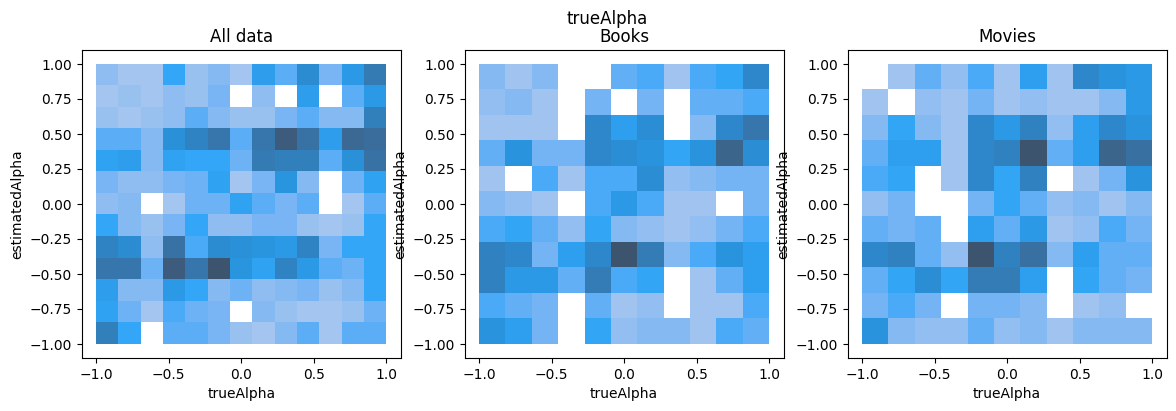

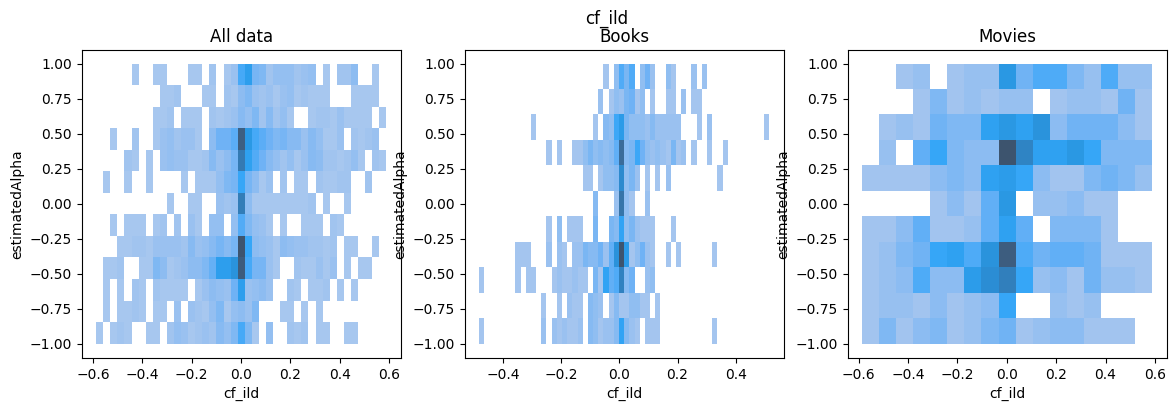

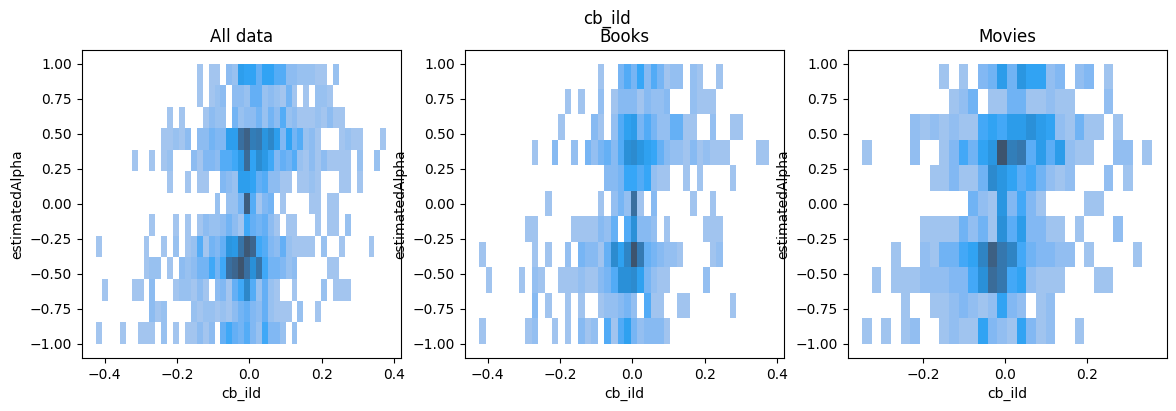

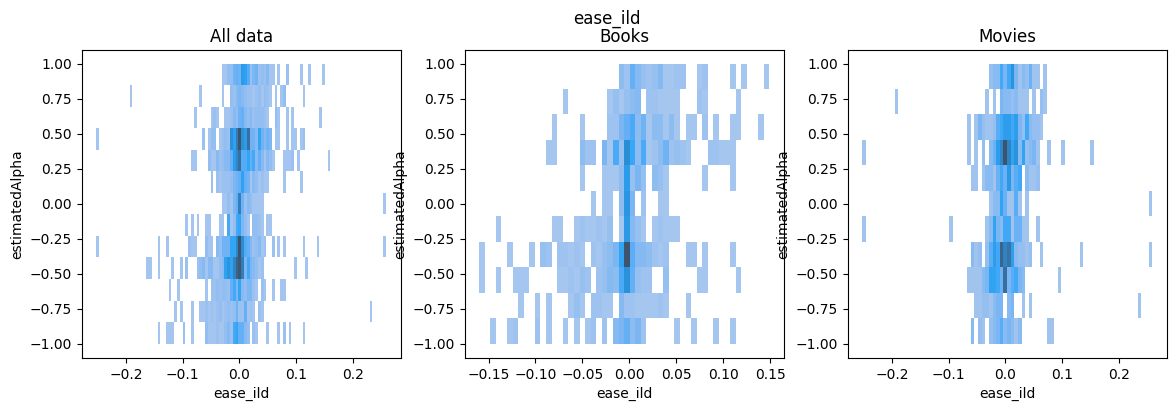

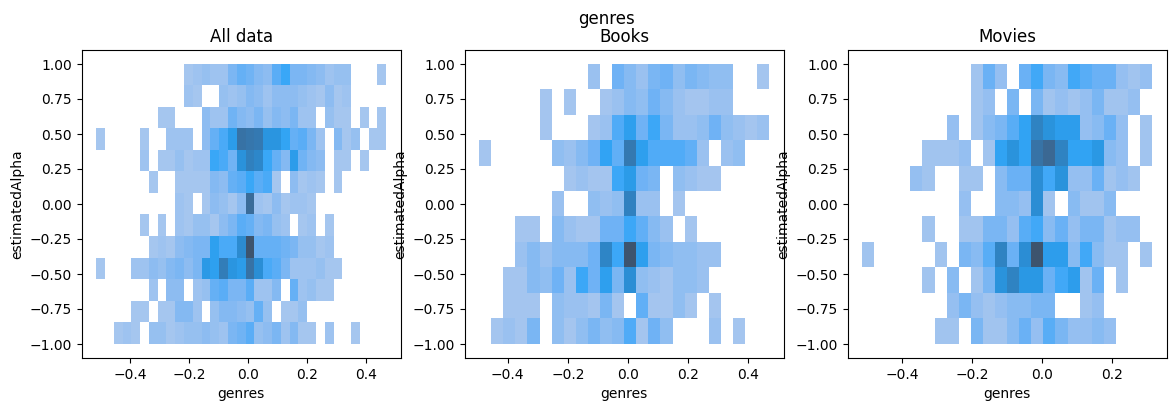

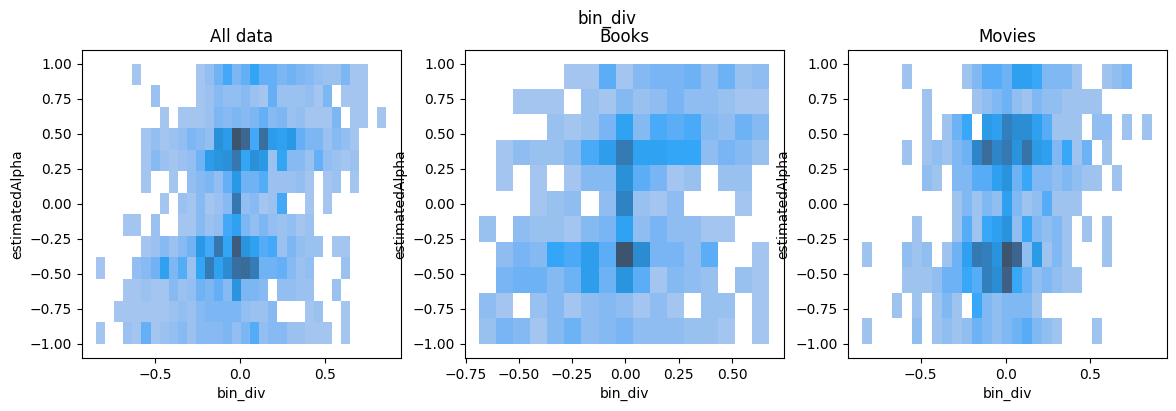

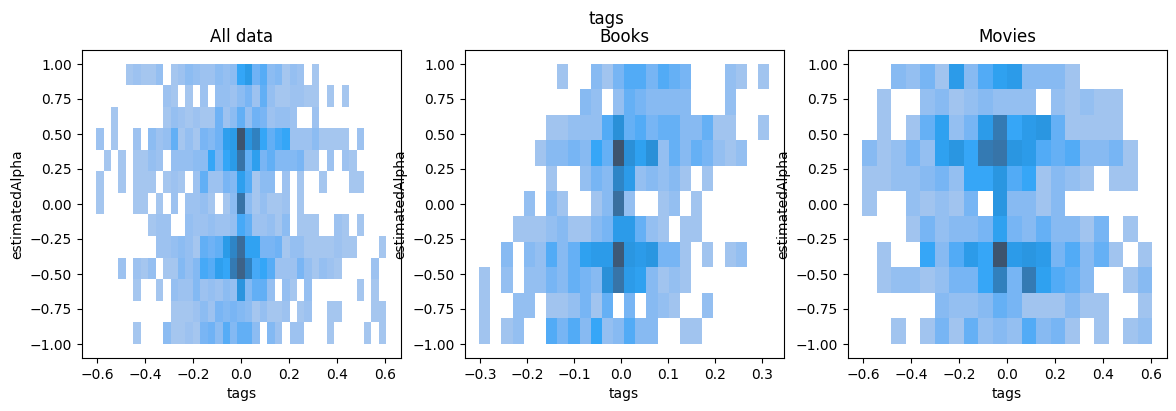

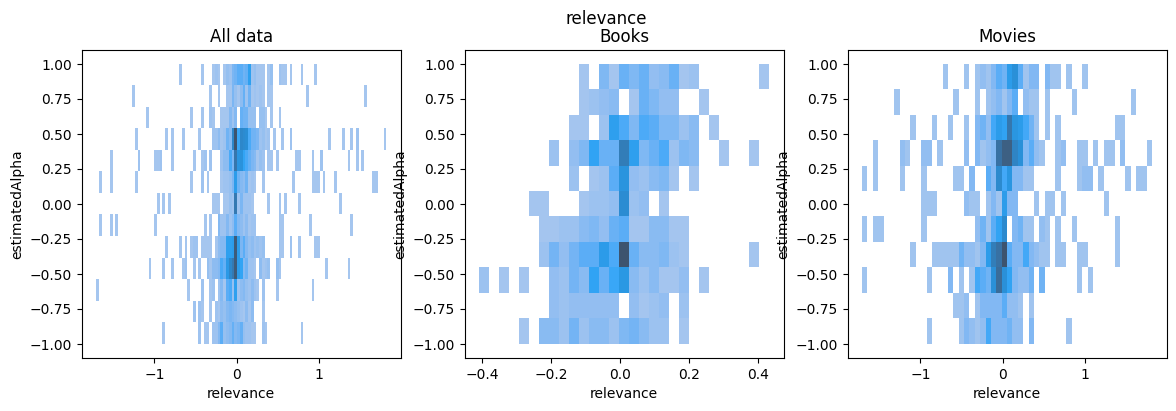

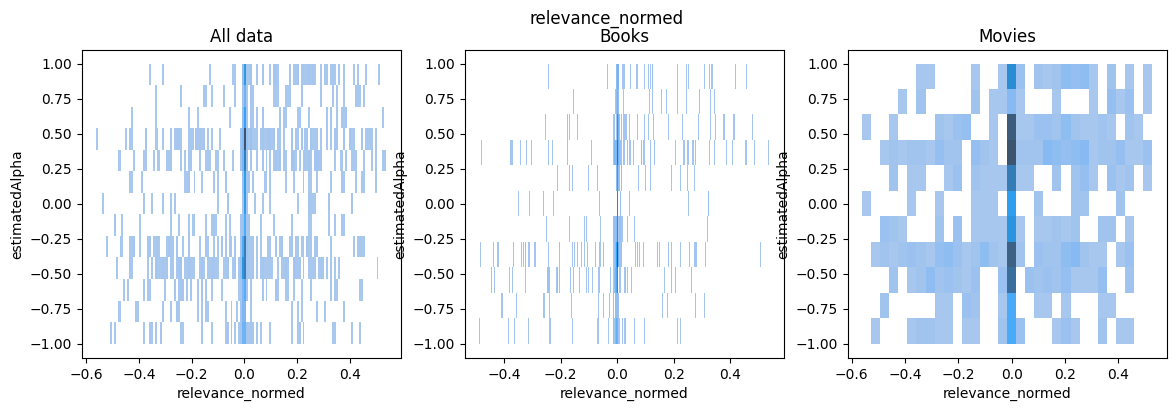

In [108]:
for f in ["trueAlpha"]  + metric_names + ["relevance", "relevance_normed"]:    
    fig, ax = plt.subplots(1,3, figsize=(14,4))
    sns.histplot(dfca_fullPair, x=f, y="estimatedAlpha", ax=ax[0])
    sns.histplot(dfca_booksPair, x=f, y="estimatedAlpha", ax=ax[1])
    sns.histplot(dfca_moviesPair, x=f, y="estimatedAlpha", ax=ax[2])
    ax[0].set_title("All data")
    ax[1].set_title("Books")
    ax[2].set_title("Movies")
    fig.suptitle(f)
    plt.show()

In [109]:
corrs = {}
v = ["all","books","movies"]
for i,d in enumerate([df_alphas_ended,df_alphas_ended_books,df_alphas_ended_movies]):  
    for m in df_alphas_ended.compare_alphas_metric.unique():  
        dtr = d.loc[d.compare_alphas_metric == m]
        dfCorr = get_dfCompareAlphaPairs(dtr)
        #print(dfCorr.trueAlpha.abs().mean()) perceived differenceis not caused by different distances in thresholds
        corrs[(v[i],m)] = [dfCorr.corr(numeric_only=True).iloc[1,0],len(dfCorr)]

corrs

{('all', 'BIN-DIV'): [0.2097451218957428, 432],
 ('all', 'CF-ILD'): [0.36462689885998434, 432],
 ('all', 'CB-ILD'): [0.323281186179513, 432],
 ('books', 'BIN-DIV'): [0.15207733830557432, 222],
 ('books', 'CF-ILD'): [0.4119016186389804, 216],
 ('books', 'CB-ILD'): [0.34745536644830133, 192],
 ('movies', 'BIN-DIV'): [0.28019854478028833, 210],
 ('movies', 'CF-ILD'): [0.30559832710176615, 216],
 ('movies', 'CB-ILD'): [0.30411969645575376, 240]}

In [110]:
for i in corrs.keys():
    for j in corrs.keys():
        if i[0] == j[0] and i[1]!=j[1]:
            print(i,j)
            print(independent_corr(corrs[i][0], corrs[j][0], corrs[i][1], corrs[j][1], twotailed=False))



('all', 'BIN-DIV') ('all', 'CF-ILD')
(2.47964325317902, 0.006575694501202212)
('all', 'BIN-DIV') ('all', 'CB-ILD')
(1.7926802882711192, 0.036512030081138125)
('all', 'CF-ILD') ('all', 'BIN-DIV')
(2.47964325317902, 0.006575694501202212)
('all', 'CF-ILD') ('all', 'CB-ILD')
(0.6869629649079008, 0.24605303344399165)
('all', 'CB-ILD') ('all', 'BIN-DIV')
(1.7926802882711192, 0.036512030081138125)
('all', 'CB-ILD') ('all', 'CF-ILD')
(0.6869629649079008, 0.24605303344399165)
('books', 'BIN-DIV') ('books', 'CF-ILD')
(2.957707326867247, 0.0015496812173043661)
('books', 'BIN-DIV') ('books', 'CB-ILD')
(2.1079084358561286, 0.017519455198230505)
('books', 'CF-ILD') ('books', 'BIN-DIV')
(2.957707326867247, 0.0015496812173043661)
('books', 'CF-ILD') ('books', 'CB-ILD')
(0.7540582910362491, 0.2254071103658375)
('books', 'CB-ILD') ('books', 'BIN-DIV')
(2.1079084358561286, 0.017519455198230505)
('books', 'CB-ILD') ('books', 'CF-ILD')
(0.7540582910362491, 0.2254071103658375)
('movies', 'BIN-DIV') ('movies

## Binary pairwise judgment

In [111]:
def get_dfCompareAlphaPairsBinnary(df_alphas_ended):
    alphaLists = []
    for i, row in df_alphas_ended.iterrows():
            for i,alpha1 in enumerate(row.alphas):
                for j,alpha2 in enumerate(row.alphas):
                    if i<j:  
                        alpha = np.sign(alpha1-alpha2)
                        est_alpha = np.sign(row.approx_alphas[i] - row.approx_alphas[j])
                        metric_deltas = [np.sign(row[metric_name][i] - row[metric_name][j]) for metric_name in metric_names]
                        RELEVANCE = np.sign(row["relevance"][j] - row["relevance"][i])
                        RELEVANCE_NORMED = np.sign(row["relevance_normed"][j] - row["relevance_normed"][i])
                        alphaLists.append([alpha,est_alpha] + metric_deltas + [RELEVANCE, RELEVANCE_NORMED])

    dfCompareAlpha = pd.DataFrame(alphaLists)
    dfCompareAlpha.columns = ["trueAlpha","estimatedAlpha"] + metric_names + ["relevance", "relevance_normed"]
    dfCompareAlpha["trueAlphaStr"] = dfCompareAlpha["trueAlpha"].astype(str)
    dfCompareAlpha = dfCompareAlpha.sort_values("trueAlpha")
    return dfCompareAlpha

In [112]:
def bin_correct(df, seedCol):
    d = {}
    for i in df.columns:
        d[i] = (df[seedCol]==df[i]).sum()/df[i].count()
    df = pd.Series(d)
    df.name = seedCol
    return df


def bin_count(df, seedCol):
    d = {}
    for i in df.columns:
        corr = (df[seedCol]==df[i]).sum()
        d[i] = [corr,df[i].count()-corr]
    df = pd.DataFrame(d).T
    df.columns = ["concordant","discordant"]
    return df



In [113]:
dfca_fullPairBin = get_dfCompareAlphaPairsBinnary(df_alphas_ended)
bin_count(dfca_fullPairBin,"estimatedAlpha").round(2).drop(["estimatedAlpha","relevance","trueAlphaStr"])

,concordant,discordant
trueAlpha,798,498
cf_ild,787,509
cb_ild,758,538
ease_ild,770,526
genres,758,538
bin_div,751,545
tags,659,637
relevance_normed,790,506


In [114]:
dfca_fullPairBin = get_dfCompareAlphaPairsBinnary(df_alphas_ended)
bin_correct(dfca_fullPairBin,"estimatedAlpha").round(2)

trueAlpha           0.62
estimatedAlpha      1.00
cf_ild              0.61
cb_ild              0.58
ease_ild            0.59
genres              0.58
bin_div             0.58
tags                0.51
relevance           0.61
relevance_normed    0.61
trueAlphaStr        0.00
Name: estimatedAlpha, dtype: float64

In [116]:
dfca_booksPairBin = get_dfCompareAlphaPairsBinnary(df_alphas_ended_books)
bin_correct(dfca_booksPairBin,"estimatedAlpha").round(2)

trueAlpha           0.63
estimatedAlpha      1.00
cf_ild              0.61
cb_ild              0.57
ease_ild            0.63
genres              0.60
bin_div             0.60
tags                0.61
relevance           0.62
relevance_normed    0.62
trueAlphaStr        0.00
Name: estimatedAlpha, dtype: float64

In [117]:
dfca_moviesPairBin = get_dfCompareAlphaPairsBinnary(df_alphas_ended_movies)
bin_correct(dfca_moviesPairBin,"estimatedAlpha").round(2)

trueAlpha           0.60
estimatedAlpha      1.00
cf_ild              0.61
cb_ild              0.60
ease_ild            0.56
genres              0.57
bin_div             0.56
tags                0.41
relevance           0.61
relevance_normed    0.60
trueAlphaStr        0.00
Name: estimatedAlpha, dtype: float64

- overall only around 60\% chance of being concordant with the user
- diversification itself got highest chance in books, while CFILD in movies - but the differences are small & insignificant

In [118]:
d = get_dfCompareAlphaPairsBinnary(df_alphas_ended)
metrics = ["cf_ild","cb_ild","ease_ild","genres","tags","bin_div","relevance_normed"]
d["posOrdering"] = (d[metrics] > 0 ).sum(axis=1)
d["negOrdering"] = (d[metrics] < 0 ).sum(axis=1)
d["samePrediction"] = d[["posOrdering","negOrdering"]].max(axis=1)
d["overallPred"] = -1.0
d.loc[(d["posOrdering"]>d["negOrdering"]),"overallPred"] = 1.0
d["correct"] = (d["overallPred"] == d["estimatedAlpha"])
d

,trueAlpha,estimatedAlpha,cf_ild,cb_ild,ease_ild,genres,bin_div,tags,relevance,relevance_normed,trueAlphaStr,posOrdering,negOrdering,samePrediction,overallPred,correct
1063,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,7,7,-1.0,False
1056,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3,4,4,-1.0,False
731,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,6,6,-1.0,False
435,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,5,2,5,1.0,False
436,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,2,5,5,-1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,2,5,5,-1.0,True
564,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,1.0,1,1,1,-1.0,False
572,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,6,1,6,1.0,True
637,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7,0,7,1.0,False


In [119]:
d["correct"].sum()/d["correct"].count()

0.6149691358024691

In [120]:
cnt = d.groupby("samePrediction")["correct"].agg(["sum","count"])
cnt = cnt.loc[[4,5,6,7]]
cnt["ratio"] = cnt["sum"] / cnt["count"] 
cnt["neg"] = cnt["count"] - cnt["sum"]
cnt.round(2)

,sum,count,ratio,neg
samePrediction,,,,
4,104,205,0.51,101
5,150,269,0.56,119
6,254,393,0.65,139
7,259,358,0.72,99


In [121]:
chi2_contingency(cnt[["sum","neg"]])

Chi2ContingencyResult(statistic=32.92759951641078, pvalue=3.335936857705213e-07, dof=3, expected_freq=array([[128.35510204,  76.64489796],
       [168.42693878, 100.57306122],
       [246.06612245, 146.93387755],
       [224.15183673, 133.84816327]]))

#### Table 4 (Bottom)

In [122]:
d = get_dfCompareAlphaPairsBinnary(df_alphas_ended)
res = pd.DataFrame(bin_correct(d,"estimatedAlpha")).T
res = res[["cf_ild","ease_ild","tags","genres","bin_div","cb_ild","relevance_normed"]]
res.round(2).to_latex()

/tmp/ipykernel_364449/229482460.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  res.round(2).to_latex()


'\\begin{tabular}{lrrrrrrr}\n\\toprule\n{} &  cf\\_ild &  ease\\_ild &  tags &  genres &  bin\\_div &  cb\\_ild &  relevance\\_normed \\\\\n\\midrule\nestimatedAlpha &    0.61 &      0.59 &  0.51 &    0.58 &     0.58 &    0.58 &              0.61 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [123]:
d = get_dfCompareAlphaPairsBinnary(df_alphas_ended_books)
res = pd.DataFrame(bin_correct(d,"estimatedAlpha")).T
res = res[["cf_ild","ease_ild","tags","genres","bin_div","cb_ild","relevance_normed"]]
res.round(2).to_latex()

/tmp/ipykernel_364449/3072387144.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  res.round(2).to_latex()


'\\begin{tabular}{lrrrrrrr}\n\\toprule\n{} &  cf\\_ild &  ease\\_ild &  tags &  genres &  bin\\_div &  cb\\_ild &  relevance\\_normed \\\\\n\\midrule\nestimatedAlpha &    0.61 &      0.63 &  0.61 &     0.6 &      0.6 &    0.57 &              0.62 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [124]:
d = get_dfCompareAlphaPairsBinnary(df_alphas_ended_movies)
res = pd.DataFrame(bin_correct(d,"estimatedAlpha")).T
res = res[["cf_ild","ease_ild","tags","genres","bin_div","cb_ild","relevance_normed"]]
res.round(2).to_latex()

/tmp/ipykernel_364449/4141496031.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  res.round(2).to_latex()


'\\begin{tabular}{lrrrrrrr}\n\\toprule\n{} &  cf\\_ild &  ease\\_ild &  tags &  genres &  bin\\_div &  cb\\_ild &  relevance\\_normed \\\\\n\\midrule\nestimatedAlpha &    0.61 &      0.56 &  0.41 &    0.57 &     0.56 &     0.6 &               0.6 \\\\\n\\bottomrule\n\\end{tabular}\n'

#### Significance

In [125]:
d = get_dfCompareAlphaPairsBinnary(df_alphas_ended)
crossTable = pd.DataFrame(bin_count(d,"estimatedAlpha"))
crossTable = crossTable.loc[["cf_ild","cb_ild","ease_ild","genres","tags","bin_div","relevance_normed"]]
crossTable

,concordant,discordant
cf_ild,787,509
cb_ild,758,538
ease_ild,770,526
genres,758,538
tags,659,637
bin_div,751,545
relevance_normed,790,506


In [126]:
from scipy.stats import chi2_contingency
print(chi2_contingency(crossTable))

Chi2ContingencyResult(statistic=37.10112900142855, pvalue=1.6827343248688472e-06, dof=6, expected_freq=array([[753.28571429, 542.71428571],
       [753.28571429, 542.71428571],
       [753.28571429, 542.71428571],
       [753.28571429, 542.71428571],
       [753.28571429, 542.71428571],
       [753.28571429, 542.71428571],
       [753.28571429, 542.71428571]]))


In [127]:
# books data
d = get_dfCompareAlphaPairsBinnary(df_alphas_ended_books)
crossTable = pd.DataFrame(bin_count(d,"estimatedAlpha"))
crossTable = crossTable.loc[["cf_ild","cb_ild","ease_ild","genres","tags","bin_div","relevance_normed"]]
crossTable

,concordant,discordant
cf_ild,383,247
cb_ild,359,271
ease_ild,397,233
genres,381,249
tags,386,244
bin_div,378,252
relevance_normed,391,239


In [128]:
print(chi2_contingency(crossTable))
#no significant differences

Chi2ContingencyResult(statistic=5.77912036413585, pvalue=0.448382593570122, dof=6, expected_freq=array([[382.14285714, 247.85714286],
       [382.14285714, 247.85714286],
       [382.14285714, 247.85714286],
       [382.14285714, 247.85714286],
       [382.14285714, 247.85714286],
       [382.14285714, 247.85714286],
       [382.14285714, 247.85714286]]))


In [129]:
#movies data
d = get_dfCompareAlphaPairsBinnary(df_alphas_ended_movies)
crossTable = pd.DataFrame(bin_count(d,"estimatedAlpha"))
crossTable = crossTable.loc[["cf_ild","cb_ild","ease_ild","genres","tags","bin_div","relevance_normed"]]
crossTable

,concordant,discordant
cf_ild,404,262
cb_ild,399,267
ease_ild,373,293
genres,377,289
tags,273,393
bin_div,373,293
relevance_normed,399,267


In [130]:
print(chi2_contingency(crossTable))

Chi2ContingencyResult(statistic=74.88555373543154, pvalue=4.052302855482325e-14, dof=6, expected_freq=array([[371.14285714, 294.85714286],
       [371.14285714, 294.85714286],
       [371.14285714, 294.85714286],
       [371.14285714, 294.85714286],
       [371.14285714, 294.85714286],
       [371.14285714, 294.85714286],
       [371.14285714, 294.85714286]]))


## Significance for RQ2 (Table 2)

In [131]:
binCounts = {}

v = ["all","books","movies"]
for i,d in enumerate([df_alphas_ended,df_alphas_ended_books,df_alphas_ended_movies]): 
    print(v[i])    
    for m in df_alphas_ended.compare_alphas_metric.unique():  
        print(m)
        dtr = d.loc[d.compare_alphas_metric == m]
        dfCorr = get_dfCompareAlphaPairsBinnary(dtr)        
        print(bin_correct(dfCorr,"estimatedAlpha").round(2).iloc[0])
        binCounts[(v[i],m)] = bin_count(dfCorr,"estimatedAlpha").iloc[0]



all
BIN-DIV
0.58
CF-ILD
0.63
CB-ILD
0.63
books
BIN-DIV
0.58
CF-ILD
0.65
CB-ILD
0.68
movies
BIN-DIV
0.59
CF-ILD
0.62
CB-ILD
0.59


In [132]:
crossTable = pd.DataFrame(binCounts).T
crossTable

concordant  discordant
all    BIN-DIV         251         181
       CF-ILD          274         158
       CB-ILD          273         159
books  BIN-DIV         128          94
       CF-ILD          141          75
       CB-ILD          131          61
movies BIN-DIV         123          87
       CF-ILD          133          83
       CB-ILD          142          98

In [134]:
from scipy.stats import chi2_contingency
print(chi2_contingency(crossTable.iloc[0:3]))
print(chi2_contingency(crossTable.iloc[3:6]))
print(chi2_contingency(crossTable.iloc[6:]))
# no significant difference for binary judgments

Chi2ContingencyResult(statistic=3.306821270042576, pvalue=0.19139601221144092, dof=2, expected_freq=array([[266., 166.],
       [266., 166.],
       [266., 166.]]))
Chi2ContingencyResult(statistic=5.4160578547297344, pvalue=0.06666808493090869, dof=2, expected_freq=array([[140.95238095,  81.04761905],
       [137.14285714,  78.85714286],
       [121.9047619 ,  70.0952381 ]]))
Chi2ContingencyResult(statistic=0.45409550417331757, pvalue=0.7968827285684631, dof=2, expected_freq=array([[125.4954955 ,  84.5045045 ],
       [129.08108108,  86.91891892],
       [143.42342342,  96.57657658]]))


In [133]:
ctDatasets = [crossTable.iloc[3:6].sum(),crossTable.iloc[6:].sum()]
ctDatasets

[concordant    400
 discordant    230
 dtype: int64,
 concordant    398
 discordant    268
 dtype: int64]

In [135]:
binCounts = {}

v = ["all","books","movies"]
for i,d in enumerate([df_alphas_ended,df_alphas_ended_books,df_alphas_ended_movies]): 
    print(v[i])    
    for m in df_alphas_ended.compare_alphas_metric.unique():  
        print(m)
        dtr = d.loc[d.compare_alphas_metric == m]
        dfCorr = get_dfCompareAlphaPairsBinnary(dtr)        
        print(bin_correct(dfCorr,"estimatedAlpha").round(3).iloc[0])
        binCounts[(v[i],m)] = bin_count(dfCorr,"estimatedAlpha").iloc[0]



all
BIN-DIV
0.581
CF-ILD
0.634
CB-ILD
0.632
books
BIN-DIV
0.577
CF-ILD
0.653
CB-ILD
0.682
movies
BIN-DIV
0.586
CF-ILD
0.616
CB-ILD
0.592


In [136]:

bin_correct(get_dfCompareAlphaPairsBinnary(df_alphas_ended),"estimatedAlpha").round(2)

trueAlpha           0.62
estimatedAlpha      1.00
cf_ild              0.61
cb_ild              0.58
ease_ild            0.59
genres              0.58
bin_div             0.58
tags                0.51
relevance           0.61
relevance_normed    0.61
trueAlphaStr        0.00
Name: estimatedAlpha, dtype: float64

In [137]:

bin_correct(get_dfCompareAlphaPairsBinnary(df_alphas_ended_books),"estimatedAlpha").round(2)

trueAlpha           0.63
estimatedAlpha      1.00
cf_ild              0.61
cb_ild              0.57
ease_ild            0.63
genres              0.60
bin_div             0.60
tags                0.61
relevance           0.62
relevance_normed    0.62
trueAlphaStr        0.00
Name: estimatedAlpha, dtype: float64

In [138]:

bin_correct(get_dfCompareAlphaPairsBinnary(df_alphas_ended_movies),"estimatedAlpha").round(2)

trueAlpha           0.60
estimatedAlpha      1.00
cf_ild              0.61
cb_ild              0.60
ease_ild            0.56
genres              0.57
bin_div             0.56
tags                0.41
relevance           0.61
relevance_normed    0.60
trueAlphaStr        0.00
Name: estimatedAlpha, dtype: float64

# Look at 2 consecutive iterations as a list of 6 values

In [140]:
df_all_six_lists = pd.read_csv("./inputs/df_all_six_lists.csv")

In [145]:
# Deserialize lists that got serialized as strings
for list_col_name in ['alphas', 'approx_alphas', 'gold', 'selected'] + metric_names + ['relevance', 'relevance_normed']:
    df_all_six_lists[list_col_name] = df_all_six_lists[list_col_name].apply(ast.literal_eval)

## Pairwise magnitude difference estimation:
- distinguish whether lists were displayed simultaneously or one after another
- while comparing pairs of lists, does the distance on axes correspond to distances w.r.t. alphas or metrics?

In [146]:
def get_dfCompareAlphaPairsWithIteration(df_alphas_ended):
    alphaLists = []
    for i, row in df_alphas_ended.iterrows():
            for i,alpha1 in enumerate(row.alphas):
                for j,alpha2 in enumerate(row.alphas):
                    if i<j:  
                        if i < 3 and j>=3: #from different steps
                            steps="different"
                        else:
                            steps="same"
                        alpha = alpha1-alpha2
                        est_alpha = row.approx_alphas[i] - row.approx_alphas[j]
                        metric_deltas = [row[metric_name][i] - row[metric_name][j] for metric_name in metric_names]
                        RELEVANCE = row["relevance"][j] - row["relevance"][i]
                        RELEVANCE_NORMED = row["relevance_normed"][j] - row["relevance_normed"][i]
                        alphaLists.append([steps,alpha,est_alpha] + metric_deltas + [RELEVANCE, RELEVANCE_NORMED])

    dfCompareAlpha = pd.DataFrame(alphaLists)
    dfCompareAlpha.columns = ["steps","trueAlpha","estimatedAlpha"] + metric_names + ["relevance", "relevance_normed"]
    dfCompareAlpha["trueAlphaStr"] = dfCompareAlpha["trueAlpha"].astype(str)
    dfCompareAlpha = dfCompareAlpha.sort_values("trueAlpha")
    return dfCompareAlpha

In [147]:
dfca_PairSteps = get_dfCompareAlphaPairsWithIteration(df_all_six_lists)
dfca_PairSteps.groupby("steps").count()

,trueAlpha,estimatedAlpha,cf_ild,cb_ild,ease_ild,genres,bin_div,tags,relevance,relevance_normed,trueAlphaStr
steps,,,,,,,,,,,
different,3888,3888,3888,3888,3888,3888,3888,3888,3888,3888,3888
same,2592,2592,2592,2592,2592,2592,2592,2592,2592,2592,2592


In [149]:
df_all_six_lists_books = df_all_six_lists.loc[df_all_six_lists.dataset=="books"]
df_all_six_lists_movies = df_all_six_lists.loc[df_all_six_lists.dataset=="movies"]

In [150]:
res = {}
v = ["all","books","movies"]
for i,d in enumerate([df_all_six_lists,df_all_six_lists_books,df_all_six_lists_movies]):   
    for m in df_all_six_lists.compare_alphas_metric.unique():  
        dtr = d.loc[d.compare_alphas_metric == m]
        dfCorr = get_dfCompareAlphaPairsWithIteration(dtr)  
        for s in ["same","different"]:
            dtrs = dfCorr.loc[dfCorr.steps == s]
                     
            res[(v[i],m,s)] = [dtrs.corr(numeric_only=True).round(2).iloc[1,0]]

pd.DataFrame(res).T


0
all    BIN-DIV same       0.21
               different  0.21
       CB-ILD  same       0.32
               different  0.27
       CF-ILD  same       0.36
               different  0.30
books  BIN-DIV same       0.15
               different  0.14
       CB-ILD  same       0.35
               different  0.29
       CF-ILD  same       0.41
               different  0.35
movies BIN-DIV same       0.28
               different  0.27
       CB-ILD  same       0.30
               different  0.25
       CF-ILD  same       0.31
               different  0.24

In [151]:
res = {}
dfCorr = get_dfCompareAlphaPairsWithIteration(df_all_six_lists)  
for s in ["same","different"]:
    dtrs = dfCorr.loc[dfCorr.steps == s]                     
    res[s] = [dtrs.corr(numeric_only=True).iloc[1,0], len(dtrs)]

ct = pd.DataFrame(res).T
ct

,0,1
same,0.297858,2592.0
different,0.257483,3888.0


In [152]:
print(independent_corr(ct[0]["same"], ct[0]["different"], int(ct[1]["same"]), int(ct[1]["different"]), twotailed=False))

(1.7247181002171543, 0.042289143740770196)


In [153]:
dfca_fullPair = get_dfCompareAlphaPairs(df_alphas_ended)
dfca_fullPair.corr().round(2)

/tmp/ipykernel_364449/3842952082.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dfca_fullPair.corr().round(2)


,trueAlpha,estimatedAlpha,cf_ild,cb_ild,ease_ild,genres,bin_div,tags,relevance,relevance_normed
trueAlpha,1.00,0.30,0.75,0.64,0.54,0.69,0.69,-0.20,0.62,0.67
estimatedAlpha,0.30,1.00,0.28,0.28,0.26,0.32,0.33,0.00,0.17,0.21
cf_ild,0.75,0.28,1.00,0.58,0.55,0.55,0.51,-0.53,0.71,0.72
cb_ild,0.64,0.28,0.58,1.00,0.51,0.55,0.47,-0.13,0.40,0.43
ease_ild,0.54,0.26,0.55,0.51,1.00,0.58,0.55,0.04,0.29,0.32
genres,0.69,0.32,0.55,0.55,0.58,1.00,0.83,0.05,0.38,0.43
bin_div,0.69,0.33,0.51,0.47,0.55,0.83,1.00,0.07,0.37,0.36
tags,-0.20,0.00,-0.53,-0.13,0.04,0.05,0.07,1.00,-0.44,-0.40
relevance,0.62,0.17,0.71,0.40,0.29,0.38,0.37,-0.44,1.00,0.61
relevance_normed,0.67,0.21,0.72,0.43,0.32,0.43,0.36,-0.40,0.61,1.00


In [154]:
dfca_booksPair = get_dfCompareAlphaPairs(df_alphas_ended_books)
dfca_booksPair.corr().round(3)

/tmp/ipykernel_364449/3953359757.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dfca_booksPair.corr().round(3)


,trueAlpha,estimatedAlpha,cf_ild,cb_ild,ease_ild,genres,bin_div,tags,relevance,relevance_normed
trueAlpha,1.000,0.298,0.669,0.641,0.625,0.768,0.802,0.586,0.841,0.608
estimatedAlpha,0.298,1.000,0.389,0.283,0.360,0.406,0.379,0.383,0.385,0.260
cf_ild,0.669,0.389,1.000,0.677,0.902,0.819,0.750,0.700,0.803,0.486
cb_ild,0.641,0.283,0.677,1.000,0.613,0.632,0.605,0.504,0.726,0.438
ease_ild,0.625,0.360,0.902,0.613,1.000,0.764,0.710,0.651,0.723,0.430
genres,0.768,0.406,0.819,0.632,0.764,1.000,0.911,0.703,0.832,0.520
bin_div,0.802,0.379,0.750,0.605,0.710,0.911,1.000,0.649,0.830,0.472
tags,0.586,0.383,0.700,0.504,0.651,0.703,0.649,1.000,0.663,0.597
relevance,0.841,0.385,0.803,0.726,0.723,0.832,0.830,0.663,1.000,0.566
relevance_normed,0.608,0.260,0.486,0.438,0.430,0.520,0.472,0.597,0.566,1.000


In [155]:
dfca_moviesPair = get_dfCompareAlphaPairs(df_alphas_ended_movies)
dfca_moviesPair.corr().round(3)

/tmp/ipykernel_364449/2141459482.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dfca_moviesPair.corr().round(3)


,trueAlpha,estimatedAlpha,cf_ild,cb_ild,ease_ild,genres,bin_div,tags,relevance,relevance_normed
trueAlpha,1.000,0.298,0.877,0.646,0.447,0.597,0.564,-0.572,0.718,0.738
estimatedAlpha,0.298,1.000,0.268,0.279,0.142,0.225,0.270,-0.156,0.156,0.179
cf_ild,0.877,0.268,1.000,0.598,0.476,0.541,0.489,-0.742,0.712,0.812
cb_ild,0.646,0.279,0.598,1.000,0.393,0.454,0.315,-0.401,0.406,0.437
ease_ild,0.447,0.142,0.476,0.393,1.000,0.327,0.336,-0.251,0.252,0.256
genres,0.597,0.225,0.541,0.454,0.327,1.000,0.703,-0.295,0.375,0.392
bin_div,0.564,0.270,0.489,0.315,0.336,0.703,1.000,-0.211,0.360,0.301
tags,-0.572,-0.156,-0.742,-0.401,-0.251,-0.295,-0.211,1.000,-0.560,-0.711
relevance,0.718,0.156,0.712,0.406,0.252,0.375,0.360,-0.560,1.000,0.665
relevance_normed,0.738,0.179,0.812,0.437,0.256,0.392,0.301,-0.711,0.665,1.000


- higher correlations overall (i.e., users are much more consistent in relative judgments)
- CF-ILD and BinDiv rather consistent on books (more than mere alpha values), but no difference on movies
- strong relevance-diversity tradeoff (as expected)
- rather positive correlation between all diversity metrics: despite they do not align well in a between-task fashion, they tend to go in the same way while using a diversification function (having a common starting point will render them more alike)

In [156]:
from corrstats import independent_corr
corrs = {}
v = ["all","books","movies"]
for i,d in enumerate([df_alphas_ended,df_alphas_ended_books,df_alphas_ended_movies]):  
    for m in df_alphas_ended.compare_alphas_metric.unique():  
        dtr = d.loc[d.compare_alphas_metric == m]
        dfCorr = get_dfCompareAlpha(dtr)
        corrs[(v[i],m)] = [dfCorr.corr(numeric_only=True).iloc[1,0],len(dfCorr)]

corrs

{('all', 'BIN-DIV'): [0.17756174383756262, 432],
 ('all', 'CF-ILD'): [0.299225036780821, 432],
 ('all', 'CB-ILD'): [0.26595235833099035, 432],
 ('books', 'BIN-DIV'): [0.10596148219619694, 222],
 ('books', 'CF-ILD'): [0.34606783937203106, 216],
 ('books', 'CB-ILD'): [0.2659028907554201, 192],
 ('movies', 'BIN-DIV'): [0.2603694422802479, 210],
 ('movies', 'CF-ILD'): [0.24965844805893636, 216],
 ('movies', 'CB-ILD'): [0.26698971323583376, 240]}

In [157]:
for i in corrs.keys():
    for j in corrs.keys():
        if i[0] == j[0] and i[1]!=j[1]:
            print(i,j)
            print(independent_corr(corrs[i][0], corrs[j][0], corrs[i][1], corrs[j][1], twotailed=False))


('all', 'BIN-DIV') ('all', 'CF-ILD')
(1.8923025651591387, 0.029225339685084784)
('all', 'BIN-DIV') ('all', 'CB-ILD')
(1.3626336809342132, 0.08649899421726048)
('all', 'CF-ILD') ('all', 'BIN-DIV')
(1.8923025651591387, 0.029225339685084784)
('all', 'CF-ILD') ('all', 'CB-ILD')
(0.5296688842249255, 0.29817076261668796)
('all', 'CB-ILD') ('all', 'BIN-DIV')
(1.3626336809342132, 0.08649899421726048)
('all', 'CB-ILD') ('all', 'CF-ILD')
(0.5296688842249255, 0.29817076261668796)
('books', 'BIN-DIV') ('books', 'CF-ILD')
(2.6457180730177052, 0.0040758862335412704)
('books', 'BIN-DIV') ('books', 'CB-ILD')
(1.6728763772277366, 0.04717581754746902)
('books', 'CF-ILD') ('books', 'BIN-DIV')
(2.6457180730177052, 0.0040758862335412704)
('books', 'CF-ILD') ('books', 'CB-ILD')
(0.8858259468504912, 0.18785566283341248)
('books', 'CB-ILD') ('books', 'BIN-DIV')
(1.6728763772277366, 0.04717581754746902)
('books', 'CB-ILD') ('books', 'CF-ILD')
(0.8858259468504912, 0.18785566283341248)
('movies', 'BIN-DIV') ('mo

## Group alpha pairs into clusters
### RQ2 Results (Table 3)

In [158]:
shown_pairs_2 = pd.read_csv('./inputs/shown_pairs.csv')

In [159]:
shown_pairs_2[['end', 'correct']].groupby('end').mean('correct').round(2)

,correct
end,
HIGH,0.59
LOW,0.64
LOW-HIGH,0.70
LOW-MIDDLE,0.66
MIDDLE,0.50
MIDDLE-HIGH,0.61


In [160]:
shown_pairs_2[['end', 'correct', 'dataset']].groupby(['dataset', 'end']).mean('correct').round(2)

correct
dataset end                 
books   HIGH            0.66
        LOW             0.72
        LOW-HIGH        0.67
        LOW-MIDDLE      0.69
        MIDDLE          0.42
        MIDDLE-HIGH     0.66
movies  HIGH            0.53
        LOW             0.57
        LOW-HIGH        0.73
        LOW-MIDDLE      0.62
        MIDDLE          0.56
        MIDDLE-HIGH     0.57

In [163]:
from scipy.stats import fisher_exact
ends = ['LOW', 'MIDDLE', 'HIGH', 'LOW-HIGH', 'LOW-MIDDLE', 'MIDDLE-HIGH']
for i in range(len(ends)):
    for j in range(i):

        list1 = shown_pairs_2[shown_pairs_2.end == ends[i]].correct.values.tolist()
        list2 = shown_pairs_2[shown_pairs_2.end == ends[j]].correct.values.tolist()


        contingency_table = np.array([
                [sum(list1), sum(list2)], # Correct == True
                [len(list1) - sum(list1), len(list2) - sum(list2)] # Correct == 0
            ]
        )

        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table)  # Exclude margins for the test
        if p_value < 0.05:
            print(f"Fisher's Exact test for {ends[i]}, {ends[j]}: {p_value}")

Fisher's Exact test for MIDDLE, LOW: 0.03785624808720316
Fisher's Exact test for LOW-HIGH, MIDDLE: 0.00012795023074503535
Fisher's Exact test for LOW-HIGH, HIGH: 0.04555889667775517
Fisher's Exact test for LOW-MIDDLE, MIDDLE: 0.002942314528476618
Fisher's Exact test for MIDDLE-HIGH, MIDDLE: 0.03952991723842779
Fisher's Exact test for MIDDLE-HIGH, LOW-HIGH: 0.020076345040322057


In [164]:
# Single sided (better than middle)
from scipy.stats import fisher_exact

for i in range(len(ends)):
    for j in [1]:
        if i == j:
            continue
        list1 = shown_pairs_2[shown_pairs_2.end == ends[i]].correct.values.tolist()
        list2 = shown_pairs_2[shown_pairs_2.end == ends[j]].correct.values.tolist()


        contingency_table = np.array([
                [sum(list1), sum(list2)], # Correct == True
                [len(list1) - sum(list1), len(list2) - sum(list2)] # Correct == 0
            ]
        )

        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='greater')  # Exclude margins for the test
        if p_value < 0.05:
            print(f"Fisher's Exact test for {ends[i]}, {ends[j]}: {p_value}")

Fisher's Exact test for LOW, MIDDLE: 0.02228981828897917
Fisher's Exact test for LOW-HIGH, MIDDLE: 8.69536113500791e-05
Fisher's Exact test for LOW-MIDDLE, MIDDLE: 0.0015295628760933033
Fisher's Exact test for MIDDLE-HIGH, MIDDLE: 0.023017654508341267


In [165]:
# Single sided (worse than LOW-HIGH)
from scipy.stats import fisher_exact

for i in range(len(ends)):
    for j in [3]:
        if i == j:
            continue
        list1 = shown_pairs_2[shown_pairs_2.end == ends[i]].correct.values.tolist()
        list2 = shown_pairs_2[shown_pairs_2.end == ends[j]].correct.values.tolist()


        contingency_table = np.array([
                [sum(list1), sum(list2)], # Correct == True
                [len(list1) - sum(list1), len(list2) - sum(list2)] # Correct == 0
            ]
        )

        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='less')  # Exclude margins for the test
        if p_value < 0.05:
            print(f"Fisher's Exact test for {ends[i]}, {ends[j]}: {p_value}")

Fisher's Exact test for MIDDLE, LOW-HIGH: 8.69536113500791e-05
Fisher's Exact test for HIGH, LOW-HIGH: 0.02789142607703013
Fisher's Exact test for MIDDLE-HIGH, LOW-HIGH: 0.010422608863082087


In [166]:
# for books
from scipy.stats import fisher_exact

for i in range(len(ends)):
    for j in range(i):

        list1 = shown_pairs_2[(shown_pairs_2.end == ends[i]) & (shown_pairs_2.dataset == 'books')].correct.values.tolist()
        list2 = shown_pairs_2[(shown_pairs_2.end == ends[j]) & (shown_pairs_2.dataset == 'books')].correct.values.tolist()


        contingency_table = np.array([
                [sum(list1), sum(list2)], # Correct == True
                [len(list1) - sum(list1), len(list2) - sum(list2)] # Correct == 0
            ]
        )

        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table)  # Exclude margins for the test
        if p_value < 0.05:
            print(f"Fisher's Exact test for {ends[i]}, {ends[j]}: {p_value}")

Fisher's Exact test for MIDDLE, LOW: 0.0030266819963632617
Fisher's Exact test for HIGH, MIDDLE: 0.013718202335149017
Fisher's Exact test for LOW-HIGH, MIDDLE: 0.0009357954404099059
Fisher's Exact test for LOW-MIDDLE, MIDDLE: 0.0004019689177464103
Fisher's Exact test for MIDDLE-HIGH, MIDDLE: 0.00266603515574865


In [167]:
# for books, single sided
from scipy.stats import fisher_exact

for i in range(len(ends)):
    for j in [1]:
        if i == j:
            continue
        list1 = shown_pairs_2[(shown_pairs_2.end == ends[i]) & (shown_pairs_2.dataset == 'books')].correct.values.tolist()
        list2 = shown_pairs_2[(shown_pairs_2.end == ends[j]) & (shown_pairs_2.dataset == 'books')].correct.values.tolist()


        contingency_table = np.array([
                [sum(list1), sum(list2)], # Correct == True
                [len(list1) - sum(list1), len(list2) - sum(list2)] # Correct == 0
            ]
        )

        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='greater')  # Exclude margins for the test
        if p_value < 0.05:
            print(f"Fisher's Exact test for {ends[i]}, {ends[j]}: {p_value}")

Fisher's Exact test for LOW, MIDDLE: 0.0023169670339965986
Fisher's Exact test for HIGH, MIDDLE: 0.009837048896310416
Fisher's Exact test for LOW-HIGH, MIDDLE: 0.0006486143446096849
Fisher's Exact test for LOW-MIDDLE, MIDDLE: 0.00028245138135596647
Fisher's Exact test for MIDDLE-HIGH, MIDDLE: 0.0019568964671371585


In [168]:
# for books, single sided (for low)
from scipy.stats import fisher_exact

for i in range(len(ends)):
    for j in [0]:
        if i == j:
            continue
        list1 = shown_pairs_2[(shown_pairs_2.end == ends[i]) & (shown_pairs_2.dataset == 'books')].correct.values.tolist()
        list2 = shown_pairs_2[(shown_pairs_2.end == ends[j]) & (shown_pairs_2.dataset == 'books')].correct.values.tolist()


        contingency_table = np.array([
                [sum(list1), sum(list2)], # Correct == True
                [len(list1) - sum(list1), len(list2) - sum(list2)] # Correct == 0
            ]
        )

        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='less')  # Exclude margins for the test
        if p_value < 0.05:
            print(f"Fisher's Exact test for {ends[i]}, {ends[j]}: {p_value}")

Fisher's Exact test for MIDDLE, LOW: 0.0023169670339965986


In [169]:
# for Movies
from scipy.stats import fisher_exact

for i in range(len(ends)):
    for j in range(i):

        list1 = shown_pairs_2[(shown_pairs_2.end == ends[i]) & (shown_pairs_2.dataset == 'movies')].correct.values.tolist()
        list2 = shown_pairs_2[(shown_pairs_2.end == ends[j]) & (shown_pairs_2.dataset == 'movies')].correct.values.tolist()


        contingency_table = np.array([
                [sum(list1), sum(list2)], # Correct == True
                [len(list1) - sum(list1), len(list2) - sum(list2)] # Correct == 0
            ]
        )

        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table)  # Exclude margins for the test
        if p_value < 0.05:
            print(f"Fisher's Exact test for {ends[i]}, {ends[j]}: {p_value}")

Fisher's Exact test for LOW-HIGH, MIDDLE: 0.03386776139389215
Fisher's Exact test for LOW-HIGH, HIGH: 0.011989837123155572
Fisher's Exact test for MIDDLE-HIGH, LOW-HIGH: 0.0035661555893708166


In [170]:
# for Movies
from scipy.stats import fisher_exact

for i in range(len(ends)):
    for j in [3]:
        if i == j:
            continue

        list1 = shown_pairs_2[(shown_pairs_2.end == ends[i]) & (shown_pairs_2.dataset == 'movies')].correct.values.tolist()
        list2 = shown_pairs_2[(shown_pairs_2.end == ends[j]) & (shown_pairs_2.dataset == 'movies')].correct.values.tolist()


        contingency_table = np.array([
                [sum(list1), sum(list2)], # Correct == True
                [len(list1) - sum(list1), len(list2) - sum(list2)] # Correct == 0
            ]
        )

        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='less')  # Exclude margins for the test
        if p_value < 0.05:
            print(f"Fisher's Exact test for {ends[i]}, {ends[j]}: {p_value}")

Fisher's Exact test for LOW, LOW-HIGH: 0.03561712534243473
Fisher's Exact test for MIDDLE, LOW-HIGH: 0.018885872338833962
Fisher's Exact test for HIGH, LOW-HIGH: 0.006201003951344832
Fisher's Exact test for LOW-MIDDLE, LOW-HIGH: 0.03537703147767824
Fisher's Exact test for MIDDLE-HIGH, LOW-HIGH: 0.002412554247696303


In [171]:
# for Movies (and for high which is the worst one)
from scipy.stats import fisher_exact

for i in range(len(ends)):
    for j in [2]:
        if i == j:
            continue

        list1 = shown_pairs_2[(shown_pairs_2.end == ends[i]) & (shown_pairs_2.dataset == 'movies')].correct.values.tolist()
        list2 = shown_pairs_2[(shown_pairs_2.end == ends[j]) & (shown_pairs_2.dataset == 'movies')].correct.values.tolist()


        contingency_table = np.array([
                [sum(list1), sum(list2)], # Correct == True
                [len(list1) - sum(list1), len(list2) - sum(list2)] # Correct == 0
            ]
        )

        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='less')  # Exclude margins for the test
        if p_value < 0.05:
            print(f"Fisher's Exact test for {ends[i]}, {ends[j]}: {p_value}")

In [172]:
def set_is_same_end(row):
    
    if row.end == 'LOW' or row.end == 'HIGH' or row.end == 'MIDDLE':
        row['is_same'] = 1
    else:
        row['is_same'] = 0
    
    return row

pairs = shown_pairs_2.apply(set_is_same_end, axis=1)


list1 = pairs[(pairs.is_same == 1)].correct.values.tolist()
list2 = pairs[(pairs.is_same == 0)].correct.values.tolist()


contingency_table = np.array([
        [sum(list1), sum(list2)], # Correct == True
        [len(list1) - sum(list1), len(list2) - sum(list2)] # Correct == 0
    ]
)

# Perform Fisher's exact test
odds_ratio, p_value = fisher_exact(contingency_table)  # Exclude margins for the test

print(f"Fisher's Exact test {p_value}")

pairs.groupby("is_same").mean('correct')

Fisher's Exact test 0.009391746950571652


,participation,alpha_1,alpha_2,correct,disparity,iteration,matches
is_same,,,,,,,
0,195.979424,0.190885,0.799558,0.653292,0.399752,0.5,0.800412
1,196.709877,0.437377,0.605802,0.570988,0.417442,0.5,0.765432


## Figure 4

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


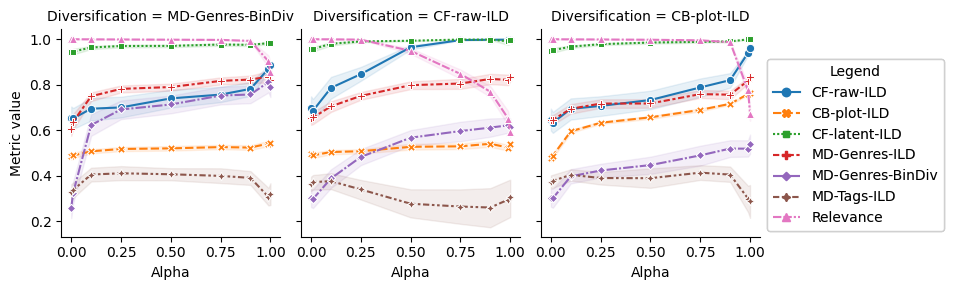

In [175]:
new_metric_names = {
    'cf_ild': "CF-raw-ILD",
    'cb_ild': "CB-plot-ILD",
    'ease_ild': "CF-latent-ILD",
    'genres': "MD-Genres-ILD",
    'bin_div': "MD-Genres-BinDiv",
    'tags': "MD-Tags-ILD"
}

mapping2 = {
    "BIN-DIV": "MD-Genres-BinDiv",
    "CF-ILD": "CF-raw-ILD",
    "CB-ILD": "CB-plot-ILD"
}

df_alphas_started2 = df_alphas_started.copy()
df_alphas_started2 = df_alphas_started2.rename(columns={"relevance_normed": "Relevance"})
df_alphas_started2.diversification_metric = df_alphas_started2.diversification_metric.map(mapping2.__getitem__)

g = sns.FacetGrid(
    df_alphas_started2\
        .rename(columns=new_metric_names).melt(value_vars=list(new_metric_names.values()) + ['Relevance'], id_vars=['diversification_metric', 'alpha', 'participation', 'dataset'])\
        .rename(columns={'value': "Metric value", 'alpha': "Alpha" , "diversification_metric": "Diversification"}),
    col="Diversification",
    sharex=True,
    sharey=True
)


def plot_facet_2(x, y1, hue, **kwargs):


    ax1 = sns.lineplot(x=x, y=y1, markers=True, err_kws={"alpha": .1}, hue=hue, style=hue, **kwargs)
    #ax2 = ax1.twinx()
#     kwargs2 = kwargs.copy()
#     kwargs2['color'] = 'pink'
#     g2 = sns.lineplot(x=x, y=y2, ax=ax2, label='Relevance', marker='^', **kwargs2)
    
#     g2.set_ylim(y2_min * 0.9, y2_max * 1.1)
    
#     # Get legend handles and labels for both axes
    h1, l1 = ax1.get_legend_handles_labels()
#     h2, l2 = ax2.get_legend_handles_labels()

#     # Combine legend handles and labels
#     handles = h1 + h2
#     labels = l1 + l2

#     # Remove legends from both axes
    ax1.legend_.remove()
#     ax2.legend_.remove()
# #     # Create a new legend on the first axis, and remove the legend from the second axis
# #     ax1.legend(handles, labels, title='Legend')
# #     ax2.get_legend().remove()

#     # Create a new legend on the FacetGrid
    ax1.figure.legend(h1, l1, title='Legend', bbox_to_anchor=(0.85, 0.5), loc='center left')
    
#     # Adjust ticks for ax2 only on the last facet
#     if facet_idx != 2:
#         ax2.set_yticks([])
#         ax2.set_ylabel('')
    
#     facet_idx += 1
    
g.map(plot_facet_2, 'Alpha', 'Metric value', 'variable')

#g.add_legend(title='Legend', bbox_to_anchor=(0.85, 0.5), loc='center left')

#g.add_legend(title='Legend', bbox_to_anchor=(0.9, 0.5), loc='center left', labels=list(new_metric_names)+['Relevance'])

# Adjust layout to make room for the combined legend
plt.subplots_adjust(right=0.85)




#plt.savefig("./results/diversificationDifferences.pdf", bbox_inches='tight', pad_inches = 0)